In [1]:
import warnings
warnings.filterwarnings('ignore')

_EPSILON = 1e-08

import numpy as np
import pandas as pd
import tensorflow as tf
import random
import os

from tensorflow.contrib.layers import fully_connected as FC_Net
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split

from sksurv.metrics import concordance_index_ipcw, concordance_index_censored, brier_score

from helpers.data_loader import *
from helpers.utils_others import *

from models.model import *
from helpers.utils_others import *

### IMPORT DATASET

In [2]:
OUT_ITERATION               = 5
data_mode                   = 'STRATCANS_v1_new2'
seed                        = 1234

(data_xs, data_xt, data_time, data_y, data_tte), (feat_static, feat_timevarying), (xt_bin_list, xt_con_list) = import_dataset_STRATCANS_v1()

# removes first and secondary pearson score
data_xs           = data_xs[:, [0,1,2,3,4,5,6]]
feat_static       = feat_static[[0,1,2,3,4,5,6]]

data_xt           = data_xt[:, :, [0,1,2,3,6,7,8,9,10]]
feat_timevarying  = feat_timevarying[[0,1,2,3,6,7,8,9,10]]
xt_con_list       = [0, 1, 2, 3, 4, 5, 6, 7]

x_dim_static      = len(feat_static)
x_dim_timevarying = len(feat_timevarying) # this includes delta

max_length                  = np.shape(data_time)[1]
num_Event                   = len(np.unique(data_y)) - 1  #number of next outcome events

data_y_new   = np.zeros([np.shape(data_y)[0], max_length, num_Event])
data_tte_new = np.zeros([np.shape(data_y)[0], max_length, num_Event])

seq_length = np.sum(np.sum(data_xt, axis=2) != 0, axis=1)

for i in range(np.shape(data_y)[0]):
    data_y_new[i, :seq_length[i], :]   = data_y[i]
    data_tte_new[i, :seq_length[i], :] = data_tte[i]

In [3]:
#====================================================
##### HYPER-PARAMETERS
mb_size                     = 64

iteration                   = 50000

keep_prob                   = 0.6
lr_train                    = 5e-4

h_dim_RNN                   = 100
h_dim_FC                    = 100

num_layers_RNN              = 2
num_layers_FC               = 3


RNN_type                    = 'GRU' #GRU, LSTM
BiRNN                       = None #if not 'None''BiRNN'

FC_active_fn                = tf.nn.relu

initial_W                   = tf.contrib.layers.xavier_initializer()

alpha                       = 1.0  #for stepahead-prediction loss
p_weibull                   = 1.0 #1.1  #1.0 # 0.5 or 1.0 performed good...


reg_scale                   = 0.


##### MAKE DICTIONARIES
# INPUT DIMENSIONS
input_dims                  = { 'x_dim_static'      : x_dim_static,
                                'x_dim_timevarying' : x_dim_timevarying, #this includes delta
                                'num_Event'         : num_Event,         #next-event types
                                'xt_con_list'       : xt_con_list,
                                'xt_bin_list'       : xt_bin_list,
                                'max_length'        : max_length }

# NETWORK HYPER-PARMETERS
network_settings            = { 'p_weibull'         : p_weibull,
                                'h_dim_RNN'         : h_dim_RNN,
                                'h_dim_FC'          : h_dim_FC,
                                'num_layers_RNN'    : num_layers_RNN,
                                'num_layers_FC'     : num_layers_FC,
                                'RNN_type'          : RNN_type,
                                'BiRNN'             : BiRNN,
                                'FC_active_fn'      : FC_active_fn,
                                'RNN_active_fn'     : tf.nn.tanh,
                                'initial_W'         : initial_W,
                                'reg_scale'         : reg_scale}

In [4]:
seed = 1234
out_itr = 2

In [5]:
PRED_TIMES = [0, 365, 365*2, 365*3]
EVAL_TIMES = [365, 365*2, 365*3, 365*4, 365*5, 365*6, 365*7, 365*8, 365*9, 365*10]

FINAL_RESULT1 = np.zeros([OUT_ITERATION, len(PRED_TIMES), len(EVAL_TIMES)])
FINAL_RESULT2 = np.zeros([OUT_ITERATION, len(PRED_TIMES), len(EVAL_TIMES)])

save_path = './{}/p{}/itr{}'.format(data_mode, p_weibull, out_itr)

if not os.path.exists(save_path + '/models/'):
    os.makedirs(save_path + '/models/')

if not os.path.exists(save_path + '/results/'):
    os.makedirs(save_path + '/results/')

(tr_data_s,te_data_s, tr_data_t,te_data_t, tr_time,te_time, tr_tte,te_tte, tr_label,te_label, tr_tte_new,te_tte_new, tr_label_new,te_label_new) = train_test_split(
    data_xs, data_xt, data_time, data_tte, data_y, data_tte_new, data_y_new, test_size=0.2, random_state=seed+out_itr
) 

(tr_data_s,va_data_s, tr_data_t,va_data_t, tr_time,va_time, tr_tte,va_tte, tr_label,va_label, tr_tte_new,va_tte_new, tr_label_new,va_label_new) = train_test_split(
    tr_data_s, tr_data_t, tr_time, tr_tte, tr_label, tr_tte_new, tr_label_new, test_size=0.2, random_state=seed+out_itr
)

tf.reset_default_graph()
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)
# config      = tf.ConfigProto(gpu_options=gpu_options)
config      = tf.ConfigProto()
sess        = tf.Session(config=config)
model       = Model_DeepHit_Weibull(sess, "Version1", input_dims, network_settings)

saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

CHECK_STEP = 100

min_loss = 1e8
max_flag = 50

avg_loss_tte   = 0   
avg_loss_mle   = 0
stopflag = 0


xs_mb, xt_mb, t_mb, tte_mb, m_mb = f_get_minibatch(
    mb_size, tr_data_s, tr_data_t, tr_time, tr_tte_new, tr_label_new
)

saver.restore(sess, save_path + '/models/model_tte')
enc_vars   = sess.run(model.enc_vars)
pred_vars  = sess.run(model.pred_vars)

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.



Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.

In [6]:
h_dim_selector       = 100
num_layers_selector  = 3

# h_dim_selector       = 100
# num_layers_selector  = 2

K     = 10
z_dim = h_dim_RNN * num_layers_RNN

network_settings['h_dim_s']         = h_dim_selector
network_settings['num_layers_s']    = num_layers_selector

input_dims['max_cluster'] = K



In [7]:
tf.reset_default_graph()
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)
# config      = tf.ConfigProto(gpu_options=gpu_options)
config      = tf.ConfigProto()
sess        = tf.Session(config=config)
model       = ACTPC_DeepHit_Weibull(sess, "Version1_ACTPC", input_dims, network_settings)

# saver = tf.train.Saver()
# sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer(), feed_dict={model.E:np.zeros([K, z_dim]).astype(float)})

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use `tf.random.categorical` instead.


In [8]:
saver.restore(sess, save_path + '/models_actpc (version 2 - z initialization)/model')
# saver.restore(sess, save_path + '/models_actpc (version 1 - y initialization)/model')

INFO:tensorflow:Restoring parameters from ./STRATCANS_v1_new2/p1.0/itr2/models_actpc (version 2 - z initialization)/model


In [37]:
seq_length = np.sum(tmp_m2, axis=1)

In [9]:
xs_in     = np.copy(tr_data_s)
xt_in     = np.copy(tr_data_t)

t_in      = np.copy(tr_time)
tte_in    = np.copy(tr_tte)
y_in      = np.copy(tr_label)

_, tmp_pi, tmp_m2 = model.get_zbars_and_pis_m2(xs_in, xt_in)
tmp_z = model.get_z_hats(xs_in, xt_in)

pred_y = np.argmax(tmp_pi[tmp_m2 == 1], axis=1)
cluster_list = np.unique(pred_y)

for c_idx, cluster in enumerate(cluster_list):
    print('Phenotype {}: {}'.format(c_idx, np.sum(pred_y == cluster)))

Phenotype 0: 1150
Phenotype 1: 1813
Phenotype 2: 1597
Phenotype 3: 1249


In [10]:
print(np.unique(pred_y))

pheno_list   = np.unique(pred_y)
pheno_mapper = {}

Ey = sess.run(tf.exp(model.Ey), feed_dict={model.keep_prob:1.})[np.unique(pred_y)]

for i in range(len(np.unique(pred_y))):
    pheno_mapper[pheno_list[np.argsort(Ey[:, 0])][i]] = i
    
    
pheno_list = [i for i in range(len(pheno_mapper))]

[0 3 8 9]


In [65]:
from tslearn.clustering import TimeSeriesKMeans #, to_time_series_dataset

'''
    1. tmp_z --> distance metric. --> find close pairs (from the same cluster) / distant pairs (from the distinct cluster)
    2. use dynamic time warping --> find close pairs (from the same tslearn cluster and cpg 3 but not ours)
                                --> find distant pairs (from different tslearn cluster and cpg3 but same cluster with ours)
                                
    show how these patients end up... having different outcomes & clusters.
    
'''

K = 4

km1 = TimeSeriesKMeans(n_clusters=K, metric="dtw", random_state=0)

xt_in_km = np.copy(tr_data_t)
xt_in_km[tmp_m2==0] = np.nan

km1.fit(xt_in_km)
km1.to_pickle(save_path + '/tslearn_km1.pkl')

pred_km1 = km1.predict(xt_in_km)

In [68]:
pred_km1_2 = km1.predict(xt_in_expanded)

In [66]:
xt_in_expanded = np.zeros([int(np.sum(seq_length)), max_length, x_dim_timevarying])
xs_in_expanded = np.zeros([int(np.sum(seq_length)), x_dim_static])

count = 0
for i in range(len(xt_in)):
    for t in range(int(seq_length[i])):
        xt_in_expanded[count, :(t+1), :] = xt_in[i, :(t+1), :]
        xt_in_expanded[count, (t+1):, :] = np.nan
        
        xs_in_expanded[count, :] = xs_in[i, :]
        count += 1
        

km2 = TimeSeriesKMeans(n_clusters=K, metric="dtw", random_state=0)

km2.fit(xt_in_expanded)
km2.to_pickle(save_path + '/tslearn_km2.pkl')

pred_km2 = km2.predict(xt_in_expanded)

In [69]:
pred_km2_1 = km2.predict(xt_in_km)

In [51]:
tmp_id = np.zeros_like(tmp_m2)
tmp_id[:, 0] = 1

df_first = pd.DataFrame(tmp_id[tmp_m2 == 1], columns=['first_id'])
df       = pd.DataFrame(pred_y, columns=['phenotype_curr'])
df['phenotype_curr']  = df['phenotype_curr'].apply(lambda x: pheno_mapper[x])

df = pd.concat([df_first, df], axis=1)
df['phenotype_prev'] = np.nan
df.iloc[1:, 2] = np.asarray(df['phenotype_curr'])[:-1]

pred_y = np.asarray(df['phenotype_curr'])

In [52]:
scaler_s = pickle.load(open('./data/processed/final/version1 (integrated)/scaler_s.pkl', 'rb'))
scaler_t = pickle.load(open('./data/processed/final/version1 (integrated)/scaler_t.pkl', 'rb'))

xs_max = scaler_s.data_max_[[0,1,2,3,4,5,6]]
xs_min = scaler_s.data_min_[[0,1,2,3,4,5,6]]

xt_max = scaler_t.data_max_[[0,1,2,3,6,7,8,9,10]]
xt_min = scaler_t.data_min_[[0,1,2,3,6,7,8,9,10]]

tmp_xs_ = xs_in * (xs_max - xs_min) + xs_min
tmp_xt_ = xt_in * (xt_max - xt_min) + xt_min

tmp_xs = np.tile(np.expand_dims(tmp_xs_, axis=1), [1, max_length, 1])[tmp_m2==1]
tmp_xt = tmp_xt_[tmp_m2==1]

In [53]:
seq_length = np.sum(tmp_m2, axis=1).astype(int)

In [54]:
xs_expanded = np.zeros([int(np.sum(tmp_m2)), np.shape(xs_in)[1]])
xt_expanded = np.zeros([int(np.sum(tmp_m2)), np.shape(xt_in)[1], np.shape(xt_in)[2]])

count = 0 
for i in range(len(xs_in)):
    for t in range(seq_length[i]):
        xs_expanded[count, :]      = xs_in[i, :]
        xt_expanded[count, :(t+1)] = xt_in[i, :(t+1), :]
        count += 1

In [55]:
lmbda_org = model.get_final_lambda(xs_expanded, xt_expanded)
lmbda_hat = model.get_final_lambda_hat(xs_expanded, xt_expanded)
lmbda_bar = model.get_final_lambda_bar(xs_expanded, xt_expanded)

In [56]:
risk_org = np.zeros([len(lmbda_org), 200])
risk_hat = np.zeros([len(lmbda_org), 200])
risk_bar = np.zeros([len(lmbda_org), 200])

for t in range(200):
    risk_org[:, t] = (1. - np.exp(- np.power(lmbda_org * t* 30., 1.)))[:,0]
    risk_hat[:, t] = (1. - np.exp(- np.power(lmbda_hat * t* 30., 1.)))[:,0]
    risk_bar[:, t] = (1. - np.exp(- np.power(lmbda_bar * t* 30., 1.)))[:,0]


In [57]:
km_y   = np.tile(y_in, [1, max_length])[tmp_m2==1]
km_tte = (np.tile(tte_in, [1, max_length]) - t_in[:,:,0])[tmp_m2==1]

y_structured0 =  [(km_y[pred_y == 0][i], km_tte[pred_y == 0][i]) for i in range(len(km_y[pred_y == 0]))]
y_structured0 = np.array(y_structured0, dtype=[('status', 'bool'),('time','<f8')])

y_structured1 =  [(km_y[pred_y == 1][i], km_tte[pred_y == 1][i]) for i in range(len(km_y[pred_y == 1]))]
y_structured1 = np.array(y_structured1, dtype=[('status', 'bool'),('time','<f8')])

y_structured2 =  [(km_y[pred_y == 2][i], km_tte[pred_y == 2][i]) for i in range(len(km_y[pred_y == 2]))]
y_structured2 = np.array(y_structured2, dtype=[('status', 'bool'),('time','<f8')])

y_structured3 =  [(km_y[pred_y == 3][i], km_tte[pred_y == 3][i]) for i in range(len(km_y[pred_y == 3]))]
y_structured3 = np.array(y_structured3, dtype=[('status', 'bool'),('time','<f8')])

(374,)

In [59]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns

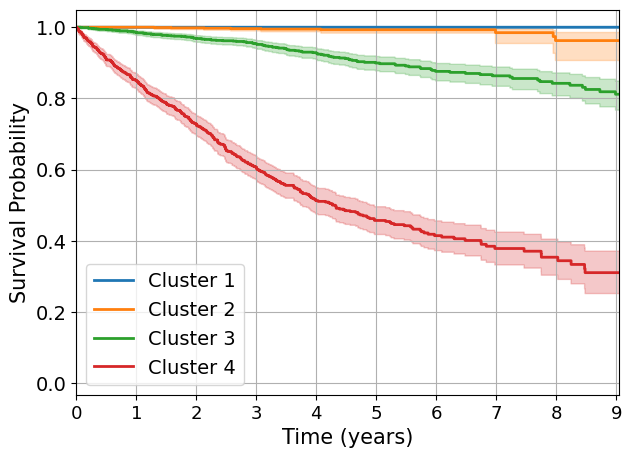

In [60]:
plt.figure(figsize=[7,5])
kmf0 = KaplanMeierFitter()
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
kmf3 = KaplanMeierFitter()

kmf0.fit(km_tte[pred_y == 0], event_observed=km_y[pred_y == 0], label="Cluster 1")
kmf1.fit(km_tte[pred_y == 1], event_observed=km_y[pred_y == 1], label="Cluster 2")
kmf2.fit(km_tte[pred_y == 2], event_observed=km_y[pred_y == 2], label="Cluster 3")
kmf3.fit(km_tte[pred_y == 3], event_observed=km_y[pred_y == 3], label="Cluster 4")

kmf0.plot_survival_function(linewidth=2.)
kmf1.plot_survival_function(linewidth=2.)
kmf2.plot_survival_function(linewidth=2.)
kmf3.plot_survival_function(linewidth=2.)

# plt.title('Survival function of political regimes')
plt.xlim([0, 3300])
plt.xticks((0., 365, 365*2, 365*3, 365*4, 365*5, 365*6, 365*7, 365*8, 365*9), (0, 1, 2, 3, 4, 5, 6, 7, 8, 9), fontsize=13)
plt.yticks(fontsize=14)
plt.xlabel('Time (years)', fontsize=15)
plt.ylabel('Survival Probability', fontsize=15)
plt.legend(fontsize=14)
plt.grid()

# plt.savefig('./phenotypes_km.png', dpi=200)
plt.show()
plt.close()

In [64]:
np.sum(pred_km2 == 1)

548

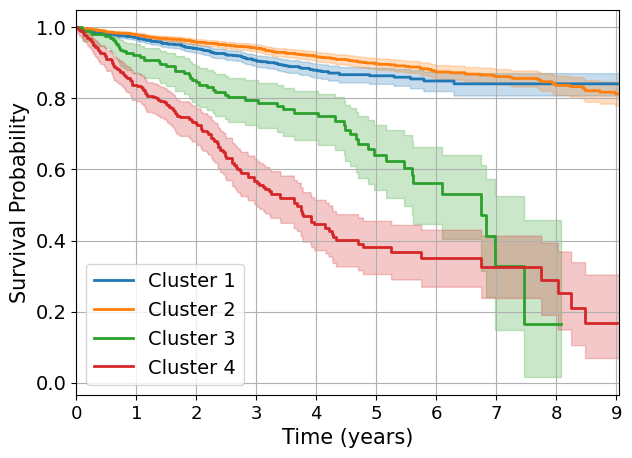

In [70]:
plt.figure(figsize=[7,5])
kmf0 = KaplanMeierFitter()
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
kmf3 = KaplanMeierFitter()

kmf0.fit(km_tte[pred_km2 == 0], event_observed=km_y[pred_km2 == 0], label="Cluster 1")
kmf1.fit(km_tte[pred_km2 == 1], event_observed=km_y[pred_km2 == 1], label="Cluster 2")
kmf2.fit(km_tte[pred_km2 == 2], event_observed=km_y[pred_km2 == 2], label="Cluster 3")
kmf3.fit(km_tte[pred_km2 == 3], event_observed=km_y[pred_km2 == 3], label="Cluster 4")

kmf0.plot_survival_function(linewidth=2.)
kmf1.plot_survival_function(linewidth=2.)
kmf2.plot_survival_function(linewidth=2.)
kmf3.plot_survival_function(linewidth=2.)

# plt.title('Survival function of political regimes')
plt.xlim([0, 3300])
plt.xticks((0., 365, 365*2, 365*3, 365*4, 365*5, 365*6, 365*7, 365*8, 365*9), (0, 1, 2, 3, 4, 5, 6, 7, 8, 9), fontsize=13)
plt.yticks(fontsize=14)
plt.xlabel('Time (years)', fontsize=15)
plt.ylabel('Survival Probability', fontsize=15)
plt.legend(fontsize=14)
plt.grid()

# plt.savefig('./phenotypes_tslearn.png', dpi=200)
plt.show()
plt.close()

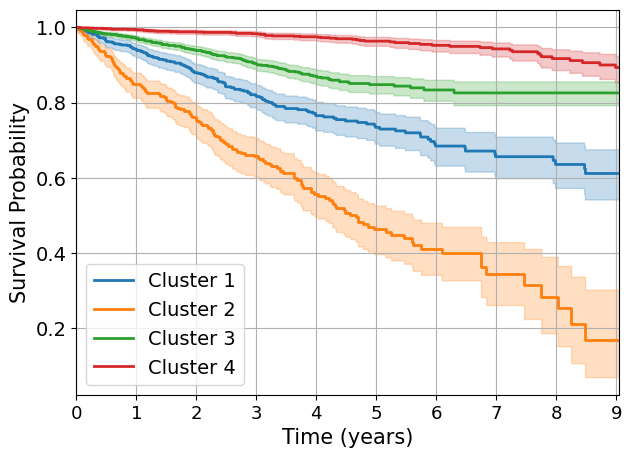

In [71]:
plt.figure(figsize=[7,5])
kmf0 = KaplanMeierFitter()
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
kmf3 = KaplanMeierFitter()

kmf0.fit(km_tte[pred_km1_2 == 0], event_observed=km_y[pred_km1_2 == 0], label="Cluster 1")
kmf1.fit(km_tte[pred_km1_2 == 1], event_observed=km_y[pred_km1_2 == 1], label="Cluster 2")
kmf2.fit(km_tte[pred_km1_2 == 2], event_observed=km_y[pred_km1_2 == 2], label="Cluster 3")
kmf3.fit(km_tte[pred_km1_2 == 3], event_observed=km_y[pred_km1_2 == 3], label="Cluster 4")

kmf0.plot_survival_function(linewidth=2.)
kmf1.plot_survival_function(linewidth=2.)
kmf2.plot_survival_function(linewidth=2.)
kmf3.plot_survival_function(linewidth=2.)

# plt.title('Survival function of political regimes')
plt.xlim([0, 3300])
plt.xticks((0., 365, 365*2, 365*3, 365*4, 365*5, 365*6, 365*7, 365*8, 365*9), (0, 1, 2, 3, 4, 5, 6, 7, 8, 9), fontsize=13)
plt.yticks(fontsize=14)
plt.xlabel('Time (years)', fontsize=15)
plt.ylabel('Survival Probability', fontsize=15)
plt.legend(fontsize=14)
plt.grid()

# plt.savefig('./phenotypes_tslearn.png', dpi=200)
plt.show()
plt.close()

In [ ]:
'''
    Now, based on the last observation; find -- using pandas frame!
'''

In [85]:
dict_km1 = {
    0:2,
    1:3,
    2:1,
    3:0   
}
pred_ykm1 = np.asarray([dict_km1[c] for c in pred_km1])

dict_km2 = {
    0:1,
    1:0,
    2:2,
    3:3   
}
pred_ykm2 = np.asarray([dict_km2[c] for c in pred_km2_1])

In [ ]:
### CPG Predictions 
data_xs_org = np.copy(data_xs)
data_xt_org = np.copy(data_xt)

data_xs_org = data_xs_org * (xs_max - xs_min) + xs_min
data_xt_org = data_xt_org * (xt_max - xt_min) + xt_min

data_xt_org = data_xt_org * (np.sum(data_xt, axis=2, keepdims=True) != 0).astype(float)

( tr_data_t_org,te_data_t_org ) = train_test_split( data_xt_org, test_size=0.2, random_state=seed+out_itr ) 
( tr_data_t_org,va_data_t_org ) = train_test_split( tr_data_t_org, test_size=0.2, random_state=seed+out_itr )

tr_data_t_org[:,:,0] = np.exp(tr_data_t_org[:, :, 0])
tr_data_t_org[tr_data_t_org[:,:,0] == 1, 0] = 0.

def predict_cpg(psa, grade, stage, is_external=False):
    cpg   = -1. * np.ones_like(psa)
    '''
    Notes:
        - There were some cases that are predicted as cpg 3. This should not happen because based on our dataset extraction process.
        - So, here we only focus on cgp 1 and cpg 2. Anything that does not belong to both will be cpg 3 (which should not happen here)

    '''
    #there were some cases that are predicted as cpg3 -- which should not happend based on the extraction criterion of the dataset. So, here we remove all the cases

    if is_external: #remove grade information -- not available for external 
        idx1  = (psa < 10.)&(stage <=1.)
        idx2  = (((psa >= 10.)&(psa <= 20.)))&(stage <= 1.)
        idx3  = (~idx1)&(~idx2)
    #     idx3  = (((psa >= 10.)&(psa <= 20.))&(stage <= 1.)) #|((grade == 3.)&(stage <= 1.))
    #     idx4  = (psa > 20.)|(stage == 2.)
    else: 
        idx1  = (grade == 1.)&(psa < 10.)&(stage <=1.)
        idx2  = ((grade == 2.)|((psa >= 10.)&(psa <= 20.)))&(stage <= 1.)
        idx3  = (~idx1)&(~idx2)
    #     idx3  = ((grade == 2.)&((psa >= 10.)&(psa <= 20.))&(stage <= 1.))|((grade == 3.)&(stage <= 1.))
    #     idx4  = (grade == 3.)|(psa > 20.)|(stage == 2.)    

    cpg[idx1] = 1.
    cpg[idx2] = 2.
    cpg[idx3] = 3.
    
    return cpg

tmp      = tr_data_t_org[tmp_m1 == 1]
pred_cpg = np.zeros([len(pred_yy)])

for i in range(len(pred_yy)):
    pred_cpg[i] = predict_cpg(tmp[i, [1]], tmp[i, [4]], tmp[i, [6]], False)

In [103]:
tmp_y     = model.get_lambdas(xs_in, xt_in)
tmp_y_hat = model.get_lambdas_hat(xs_in, xt_in)
tmp_y_bar = model.get_lambdas_bar(xs_in, xt_in)

In [104]:
for c in np.unique(pred_y):
#     print(np.mean(tmp_y[tmp_m2 == 1][pred_y == c]), np.mean(tmp_y_hat[tmp_m2 == 1][pred_y == c]),  tmp_y_bar[tmp_m2 == 1][pred_y == c][0,0])
    print(c, np.mean(tmp_y[tmp_m2 == 1][pred_y == c]), np.mean(tmp_y_hat[tmp_m2 == 1][pred_y == c]),  sess.run(tf.exp(model.Ey), feed_dict={model.keep_prob:1.})[c, 0])    

0 1.4325738e-07 6.6961854e-09 2.309768e-07
1 3.7577297e-06 1.8325552e-07 3.9519687e-06
2 3.7173508e-05 9.539776e-07 0.0009128538
3 0.00058172015 1.2660744e-05 2.2691209e-05


In [119]:
tmp_m1 = np.zeros_like(tmp_m2)
for i in range(len(seq_length)):
    tmp_m1[i, int(seq_length[i])-1] = 1.
    
pred_yy = pred_y[tmp_m1[tmp_m2 == 1]==1]

In [139]:
# y_in[363]

tte_in[363]

array([3280], dtype=int64)

In [143]:
tmp = np.zeros([len(pred_yy), 6])
tmp[:, 0] = pred_yy
tmp[:, 1] = pred_cpg
tmp[:, 2] = pred_ykm1
tmp[:, 3] = pred_ykm2

tmp[:, 4] = y_in[:, 0]
tmp[:, 5] = tte_in[:, 0]

df = pd.DataFrame(tmp, columns=['Ours', 'CPG', 'DTW-1', 'DTW-2', 'Label', 'TTE'])

In [142]:
from tslearn.metrics import dtw

dist_dtw = np.zeros([len(xt_in_km), len(xt_in_km)])

for i in range(len(dist_dtw)):
    for j in range(i, len(dist_dtw)):
        dist_dtw[i,j] = dtw(xt_in_km[i, :, :], xt_in_km[j, :, :])
        dist_dtw[j, i] = dist_dtw[i, j]

(374, 1)

In [145]:
df[(df['Ours'] == 3)&(df['Label'] == 1)]

Ours  CPG  DTW-1  DTW-2  Label     TTE
1     3.0  2.0    3.0    3.0    1.0   112.0
2     3.0  2.0    3.0    3.0    1.0   243.0
4     3.0  2.0    3.0    3.0    1.0   296.0
9     3.0  2.0    3.0    3.0    1.0   861.0
17    3.0  1.0    1.0    1.0    1.0   380.0
22    3.0  2.0    3.0    3.0    1.0  1580.0
25    3.0  3.0    2.0    0.0    1.0   365.0
30    3.0  2.0    3.0    3.0    1.0   426.0
34    3.0  3.0    2.0    0.0    1.0  2140.0
36    3.0  2.0    3.0    2.0    1.0   390.0
37    3.0  2.0    1.0    1.0    1.0  1601.0
44    3.0  2.0    1.0    3.0    1.0  2033.0
63    3.0  2.0    3.0    3.0    1.0   553.0
94    3.0  3.0    1.0    1.0    1.0  2298.0
114   3.0  3.0    2.0    0.0    1.0  3092.0
120   3.0  2.0    1.0    1.0    1.0  1266.0
149   3.0  2.0    3.0    3.0    1.0  2023.0
158   3.0  2.0    0.0    0.0    1.0  3566.0
161   3.0  2.0    3.0    3.0    1.0  2929.0
176   3.0  2.0    3.0    2.0    1.0  2724.0
183   3.0  2.0    3.0    2.0    1.0   282.0
186   3.0  2.0    2.0    0.0    1.0  1581.0
191   3.0  1.0    2.0    0.0    1.0  1197.0
199   3.0  2.0    3.0    2.0    1.0   834.0
205   3.0  2.0    3.0    2.0    1.0  2462.0
210   3.0  1.0    2.0    0.0    1.0   904.0
211   3.0  1.0    1.0    1.0    1.0  1323.0
213   3.0  1.0    1.0    1.0    1.0   140.0
221   3.0  2.0    3.0    3.0    1.0   283.0
225   3.0  2.0    2.0    0.0    1.0  4609.0
227   3.0  3.0    1.0    1.0    1.0  1422.0
231   3.0  2.0    1.0    1.0    1.0  1074.0
233   3.0  3.0    1.0    1.0    1.0  1417.0
235   3.0  2.0    2.0    0.0    1.0   716.0
236   3.0  1.0    1.0    1.0    1.0   660.0
237   3.0  2.0    0.0    0.0    1.0  4463.0
242   3.0  2.0    3.0    3.0    1.0  1447.0
253   3.0  2.0    1.0    1.0    1.0   656.0
256   3.0  2.0    2.0    0.0    1.0   665.0
259   3.0  2.0    3.0    3.0    1.0  3095.0
262   3.0  1.0    2.0    0.0    1.0  2829.0
272   3.0  2.0    3.0    3.0    1.0   839.0
275   3.0  2.0    1.0    1.0    1.0   915.0
287   3.0  2.0    1.0    3.0    1.0  1169.0
288   3.0  2.0    3.0    3.0    1.0  3772.0
328   3.0  2.0    3.0    3.0    1.0   534.0
349   3.0  2.0    2.0    0.0    1.0   971.0
363   3.0  1.0    2.0    0.0    1.0  3280.0
368   3.0  2.0    3.0    3.0    1.0  1714.0

In [206]:
i = 237
z_pca_event = pca.transform(tmp_z[i, :int(np.sum(tmp_m2[i, :])), :])

i = 326
z_pca_event0 = pca.transform(tmp_z[i, :int(np.sum(tmp_m2[i, :])), :])

i = 363
z_pca_event_tmp1 = pca.transform(tmp_z[i, :int(np.sum(tmp_m2[i, :])), :])

i = 292
z_pca_event_tmp2 = pca.transform(tmp_z[i, :int(np.sum(tmp_m2[i, :])), :])


In [214]:
print(dist_dtw[363, [237, 292]])

print(dist_dtw[237, [363, 292]])

[2.47232387 1.67494929]
[2.47232387 1.77273853]


In [207]:
np.argsort(dist_dtw[363, :])

array([363, 292, 320, 356, 340, 338,  38, 103, 321, 257,  90, 215,  84,
       138, 337, 265, 325, 134, 118, 172,  83, 139, 355, 234,   7, 235,
       317,   6,  74, 217, 160, 186, 362, 297, 157, 141,  51,  75,  85,
       255, 359, 196, 341, 167,  39, 214,  29,  73, 117, 284, 113,  99,
       304, 125, 230, 225, 219, 300, 135, 136, 349, 246,  34, 192,  58,
       188,  80, 339, 126, 209,  72, 367,  14, 281, 111, 285, 262, 102,
       266,  10, 331, 144, 237, 236, 218, 166, 123, 268, 360, 369, 131,
       110, 335,  42, 210, 105, 312, 147,  64, 100, 130, 327, 258, 308,
       150, 350, 152, 195, 326, 307, 303, 179, 156, 275,  46, 256,  20,
       206, 276, 290,  27, 291, 228, 311, 260, 249,   3,  48, 252, 365,
       148,  24,  97,  70, 305, 216,  50, 142,  47, 180, 132, 164,  28,
       173, 171, 347, 354, 213, 329, 224,  68, 295, 250,  71, 168, 289,
       274, 182, 346, 336,  62, 170, 154,  23, 128, 220,  89, 269,  40,
         0,  15, 280, 323, 140,  35, 211, 222,  78, 348, 343,  7

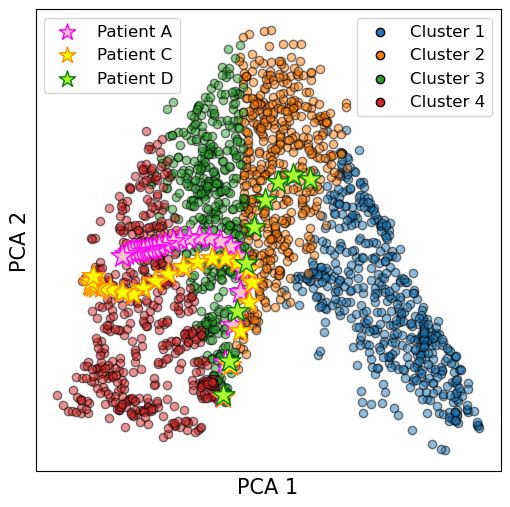

In [213]:
alpha_ = 0.5

nums = 500
idx0 = random.sample(range(np.sum(pred_y == 0)), nums)
idx1 = random.sample(range(np.sum(pred_y == 1)), nums)
idx2 = random.sample(range(np.sum(pred_y == 2)), nums)
idx3 = random.sample(range(np.sum(pred_y == 3)), nums)

fig, ax =  plt.subplots(figsize=[6,6])

pheno1 = ax.scatter(z_pca[pred_y == 0,0][0], z_pca[pred_y == 0,1][0], alpha=1.0, edgecolors='black', color='C0')
pheno2 = ax.scatter(z_pca[pred_y == 1,0][0], z_pca[pred_y == 1,1][0], alpha=1.0, edgecolors='black', color='C1')
pheno3 = ax.scatter(z_pca[pred_y == 2,0][0], z_pca[pred_y == 2,1][0], alpha=1.0, edgecolors='black', color='C2')
pheno4 = ax.scatter(z_pca[pred_y == 3,0][0], z_pca[pred_y == 3,1][0], alpha=1.0, edgecolors='black', color='C3')

ax.scatter(z_pca[pred_y == 0,0][idx0], z_pca[pred_y == 0,1][idx0], alpha=alpha_, edgecolors='black', color='C0')
ax.scatter(z_pca[pred_y == 1,0][idx1], z_pca[pred_y == 1,1][idx1], alpha=alpha_, edgecolors='black', color='C1')
ax.scatter(z_pca[pred_y == 2,0][idx2], z_pca[pred_y == 2,1][idx2], alpha=alpha_, edgecolors='black', color='C2')
ax.scatter(z_pca[pred_y == 3,0][idx3], z_pca[pred_y == 3,1][idx3], alpha=alpha_, edgecolors='black', color='C3')

line1 = ax.scatter(z_pca_event1[0, 0], z_pca_event1[0, 1], alpha=1., edgecolors='magenta', color='pink', marker='*', s= 150)
ax.scatter(z_pca_event1[:, 0], z_pca_event1[:, 1], alpha=1., edgecolors='magenta', color='pink', marker='*', s= 300)

# line2 = ax.scatter(z_pca_event0[0, 0], z_pca_event0[0, 1], alpha=1., edgecolors='blue', color='cyan', marker='*', s= 150)
# ax.scatter(z_pca_event0[:, 0], z_pca_event0[:, 1], alpha=1., edgecolors='blue', color='cyan', marker='*', s= 300)

line3 = ax.scatter(z_pca_event_tmp1[0, 0], z_pca_event_tmp1[0, 1], alpha=1., edgecolors='darkorange', color='yellow', marker='*', s= 150)
ax.scatter(z_pca_event_tmp1[:, 0], z_pca_event_tmp1[:, 1], alpha=1., edgecolors='darkorange', color='yellow', marker='*', s= 300)

line4 = ax.scatter(z_pca_event_tmp2[0, 0], z_pca_event_tmp2[0, 1], alpha=1., edgecolors='green', color='greenyellow', marker='*', s= 150)
ax.scatter(z_pca_event_tmp2[:, 0], z_pca_event_tmp2[:, 1], alpha=1., edgecolors='green', color='greenyellow', marker='*', s= 300)


ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('PCA 1', fontsize=15)
ax.set_ylabel('PCA 2', fontsize=15)

ax.legend([line1, line3, line4], ['Patient A', 'Patient C', 'Patient D'], fontsize=12, loc='upper left')
leg = Legend(ax, [pheno1, pheno2, pheno3, pheno4], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12, loc='upper right')
ax.add_artist(leg)

plt.savefig('./phenotypes_pca_comparison_to_dtw.png', dpi=200)
plt.show()
plt.close()

# plt.scatter(z_pca_last[new_pred_y_last == 1,0], z_pca_last[new_pred_y_last == 1,1], alpha=alpha_, edgecolors='black', color='C0')
# plt.scatter(z_pca_last[new_pred_y_last == 2,0], z_pca_last[new_pred_y_last == 2,1], alpha=alpha_, edgecolors='black', color='C1')
# plt.scatter(z_pca_last[new_pred_y_last == 3,0], z_pca_last[new_pred_y_last == 3,1], alpha=alpha_, edgecolors='black', color='C2')
# plt.show()
# plt.close()


In [200]:
pred_km1_2.shape

(5809,)

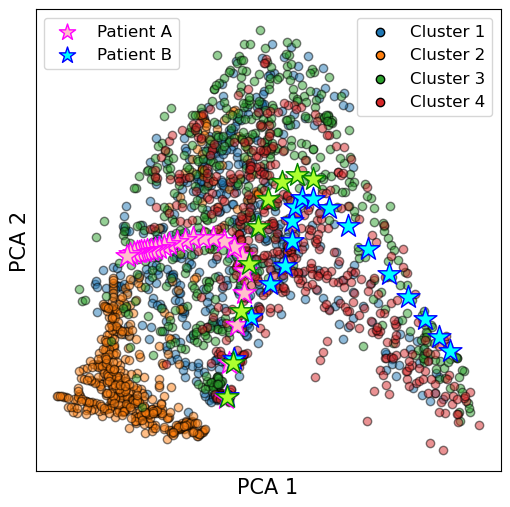

In [201]:
alpha_ = 0.5

nums = 500
idx0 = random.sample(range(np.sum(pred_km1_2 == 0)), nums)
idx1 = random.sample(range(np.sum(pred_km1_2 == 1)), nums)
idx2 = random.sample(range(np.sum(pred_km1_2 == 2)), nums)
idx3 = random.sample(range(np.sum(pred_km1_2 == 3)), nums)

fig, ax =  plt.subplots(figsize=[6,6])

pheno1 = ax.scatter(z_pca[pred_km1_2 == 0,0][0], z_pca[pred_km1_2 == 0,1][0], alpha=1.0, edgecolors='black', color='C0')
pheno2 = ax.scatter(z_pca[pred_km1_2 == 1,0][0], z_pca[pred_km1_2 == 1,1][0], alpha=1.0, edgecolors='black', color='C1')
pheno3 = ax.scatter(z_pca[pred_km1_2 == 2,0][0], z_pca[pred_km1_2 == 2,1][0], alpha=1.0, edgecolors='black', color='C2')
pheno4 = ax.scatter(z_pca[pred_km1_2 == 3,0][0], z_pca[pred_km1_2 == 3,1][0], alpha=1.0, edgecolors='black', color='C3')

ax.scatter(z_pca[pred_km1_2 == 0,0][idx0], z_pca[pred_km1_2 == 0,1][idx0], alpha=alpha_, edgecolors='black', color='C0')
ax.scatter(z_pca[pred_km1_2 == 1,0][idx1], z_pca[pred_km1_2 == 1,1][idx1], alpha=alpha_, edgecolors='black', color='C1')
ax.scatter(z_pca[pred_km1_2 == 2,0][idx2], z_pca[pred_km1_2 == 2,1][idx2], alpha=alpha_, edgecolors='black', color='C2')
ax.scatter(z_pca[pred_km1_2 == 3,0][idx3], z_pca[pred_km1_2 == 3,1][idx3], alpha=alpha_, edgecolors='black', color='C3')

line1 = ax.scatter(z_pca_event1[0, 0], z_pca_event1[0, 1], alpha=1., edgecolors='magenta', color='pink', marker='*', s= 150)
line2 = ax.scatter(z_pca_event0[0, 0], z_pca_event0[0, 1], alpha=1., edgecolors='blue', color='cyan', marker='*', s= 150)
ax.scatter(z_pca_event1[:, 0], z_pca_event1[:, 1], alpha=1., edgecolors='magenta', color='pink', marker='*', s= 300)
ax.scatter(z_pca_event0[:, 0], z_pca_event0[:, 1], alpha=1., edgecolors='blue', color='cyan', marker='*', s= 300)

ax.scatter(z_pca_event_tmp1[:, 0], z_pca_event_tmp1[:, 1], alpha=1., edgecolors='green', color='greenyellow', marker='*', s= 300)
# ax.scatter(z_pca_event_tmp2[:, 0], z_pca_event_tmp2[:, 1], alpha=1., edgecolors='green', color='greenyellow', marker='*', s= 300)


ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('PCA 1', fontsize=15)
ax.set_ylabel('PCA 2', fontsize=15)

ax.legend([line1, line2], ['Patient A', 'Patient B'], fontsize=12, loc='upper left')
leg = Legend(ax, [pheno1, pheno2, pheno3, pheno4], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12, loc='upper right')
ax.add_artist(leg)

# plt.savefig('./phenotypes_pca.png', dpi=200)
plt.show()
plt.close()

# plt.scatter(z_pca_last[new_pred_y_last == 1,0], z_pca_last[new_pred_y_last == 1,1], alpha=alpha_, edgecolors='black', color='C0')
# plt.scatter(z_pca_last[new_pred_y_last == 2,0], z_pca_last[new_pred_y_last == 2,1], alpha=alpha_, edgecolors='black', color='C1')
# plt.scatter(z_pca_last[new_pred_y_last == 3,0], z_pca_last[new_pred_y_last == 3,1], alpha=alpha_, edgecolors='black', color='C2')
# plt.show()
# plt.close()


array([5.07, 5.07, 5.13, 4.72, 5.3 , 6.05, 5.32, 5.32, 4.74, 3.89, 4.84,
       6.35, 5.58, 6.92, 6.92, 6.07, 4.24, 3.55, 3.79, 2.95, 2.95, 4.03,
       2.65, 2.47, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  ])

In [368]:
x_in_plot = np.copy(tr_data_t_org)
x_in_plot[:,:,0] = np.cumsum(x_in_plot[:,:,0], axis=1)
x_in_plot[:,:,0] = x_in_plot[:,:,0] - np.nanmax(x_in_plot[:,:,0], axis=1, keepdims=True)
x_in_plot[tmp_m2 == 0] = np.nan

x_in_plot[:, :, 0] = np.round(x_in_plot[:, :, 0]/30 * 1)

# for i in range(len(x_in_plot)):
#     x_in_plot[i, -seq_length[i]:, :] = x_in_plot[i, :seq_length[i], :]
#     x_in_plot[i, :seq_length[i], :]  = np.nan

In [369]:
c = 0
np.where(pred_yy == c)[0]

array([  6,   7,  11,  12,  14,  16,  20,  24,  38,  40,  41,  42,  45,
        46,  52,  55,  64,  65,  66,  68,  78,  79,  80,  81,  92,  99,
       105, 109, 111, 115, 121, 125, 128, 131, 135, 139, 140, 141, 160,
       165, 172, 174, 177, 179, 187, 189, 190, 193, 196, 202, 206, 207,
       212, 218, 224, 226, 229, 230, 232, 239, 243, 244, 251, 252, 267,
       276, 279, 280, 282, 283, 284, 286, 298, 300, 308, 312, 313, 318,
       323, 326, 329, 335, 340, 343, 344, 345, 348, 360, 361, 367],
      dtype=int64)

In [370]:
f_idx = 3

c = 0
for i in np.where(pred_yy == c)[0]:
    plt.plot(x_in_plot[i, :seq_length[i], 0], x_in_plot[i, :seq_length[i], f_idx], color='C{}'.format(c), alpha=0.2)
    
c = 1
for i in np.where(pred_yy == c)[0]:
    plt.plot(x_in_plot[i, :seq_length[i], 0], x_in_plot[i, :seq_length[i], f_idx], color='C{}'.format(c), alpha=0.2)
    
c = 2
for i in np.where(pred_yy == c)[0]:
    plt.plot(x_in_plot[i, :seq_length[i], 0], x_in_plot[i, :seq_length[i], f_idx], color='C{}'.format(c), alpha=0.2)
    
c = 3
for i in np.where(pred_yy == c)[0]:
    plt.plot(x_in_plot[i, :seq_length[i], 0], x_in_plot[i, :seq_length[i], f_idx], color='C{}'.format(c), alpha=0.2)
    
    
plt.show()
plt.close()

In [371]:
# x_in_plot[:,:, 1]

tmp0 = x_in_plot[pred_yy == 0][tmp_m2[pred_yy == 0] == 1]
tmp1 = x_in_plot[pred_yy == 1][tmp_m2[pred_yy == 1] == 1]
tmp2 = x_in_plot[pred_yy == 2][tmp_m2[pred_yy == 2] == 1]
tmp3 = x_in_plot[pred_yy == 3][tmp_m2[pred_yy == 3] == 1]

In [374]:
tmp00 = np.zeros([len(np.unique(tmp0[:, 0])), x_dim_timevarying, 2])
for t_idx, t in enumerate(np.unique(tmp0[:, 0])):
    tmp00[t_idx, :, 0] = np.mean(tmp0[tmp0[:, 0] == t, :], axis=0)
    tmp00[t_idx, :, 1] = np.std(tmp0[tmp0[:, 0] == t, :], axis=0)
    
tmp11 = np.zeros([len(np.unique(tmp1[:, 0])), x_dim_timevarying, 2])
for t_idx, t in enumerate(np.unique(tmp1[:, 0])):
    tmp11[t_idx, :, 0] = np.mean(tmp1[tmp1[:, 0] == t, :], axis=0)
    tmp11[t_idx, :, 1] = np.std(tmp1[tmp1[:, 0] == t, :], axis=0)
    
tmp22 = np.zeros([len(np.unique(tmp2[:, 0])), x_dim_timevarying, 2])
for t_idx, t in enumerate(np.unique(tmp2[:, 0])):
    tmp22[t_idx, :, 0] = np.mean(tmp2[tmp2[:, 0] == t, :], axis=0)
    tmp22[t_idx, :, 1] = np.std(tmp2[tmp2[:, 0] == t, :], axis=0)
    
tmp33 = np.zeros([len(np.unique(tmp3[:, 0])), x_dim_timevarying, 2])
for t_idx, t in enumerate(np.unique(tmp3[:, 0])):
    tmp33[t_idx, :, 0] = np.mean(tmp3[tmp3[:, 0] == t, :], axis=0)
    tmp33[t_idx, :, 1] = np.std(tmp3[tmp3[:, 0] == t, :], axis=0)

In [397]:
len(tmp00)

148

In [485]:
tmp = np.concatenate([
    tmp00[tmp00[:, 0, 0] > -73, :, 0],
    tmp11[tmp11[:, 0, 0] > -73, :, 0],
    tmp22[tmp22[:, 0, 0] > -73, :, 0],
    tmp33[tmp33[:, 0, 0] > -73, :, 0]
], axis=0)

tmp_margin = (np.max(tmp, axis=0)-np.min(tmp, axis=0))/30

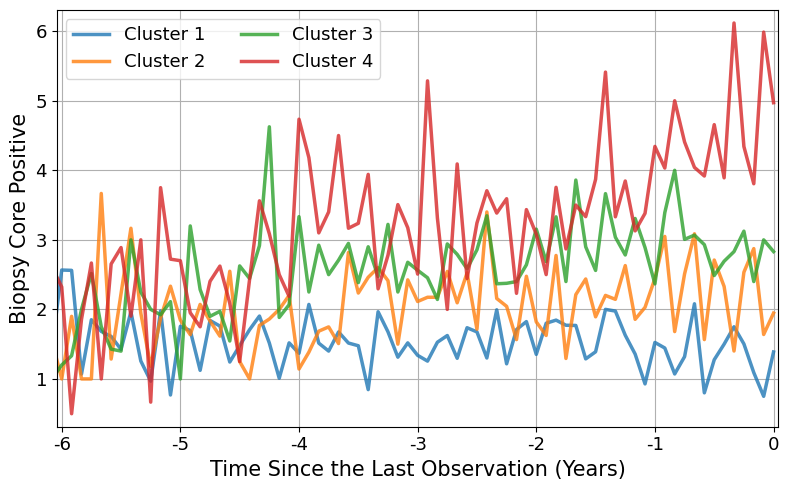

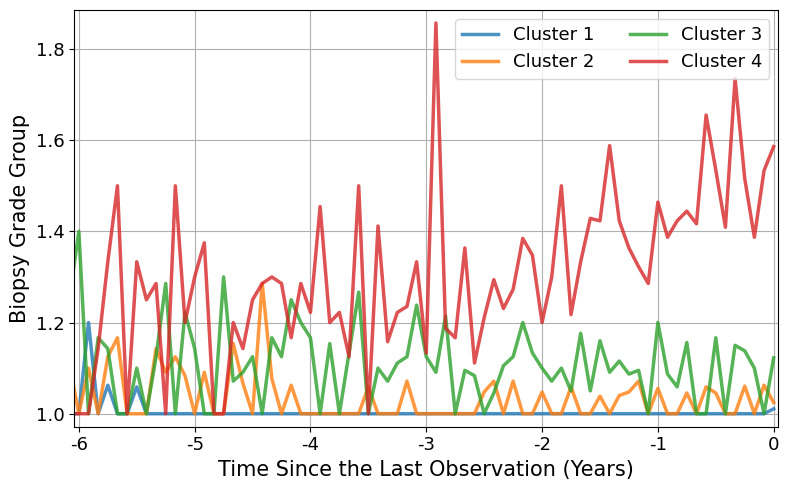

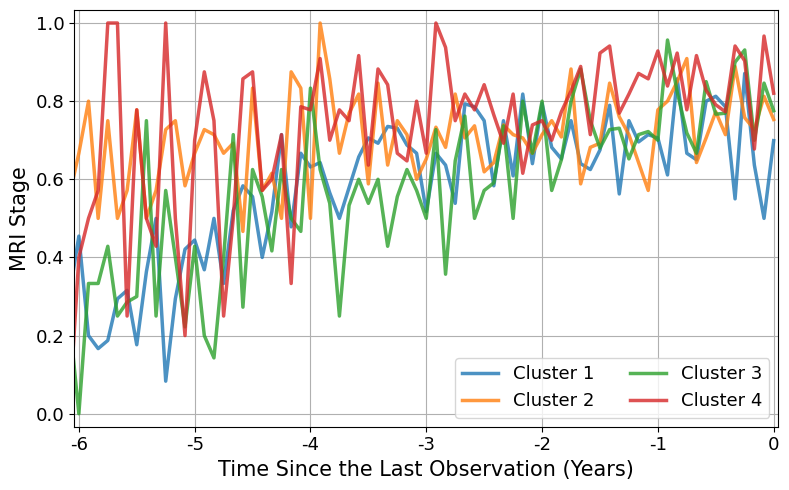

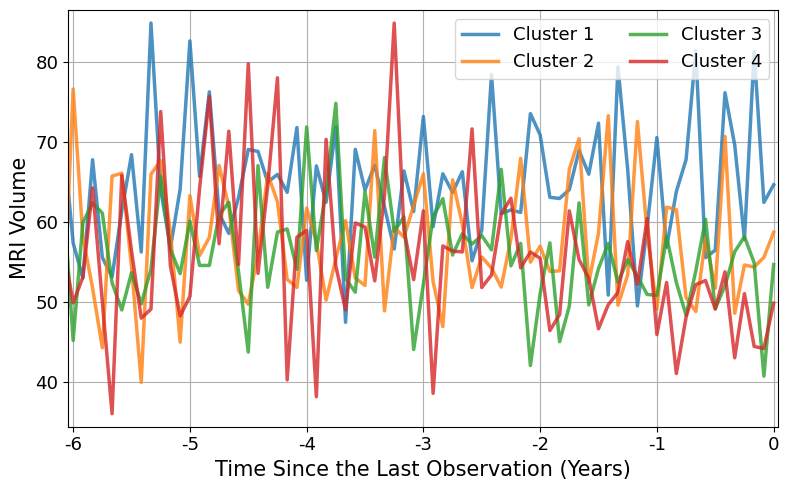

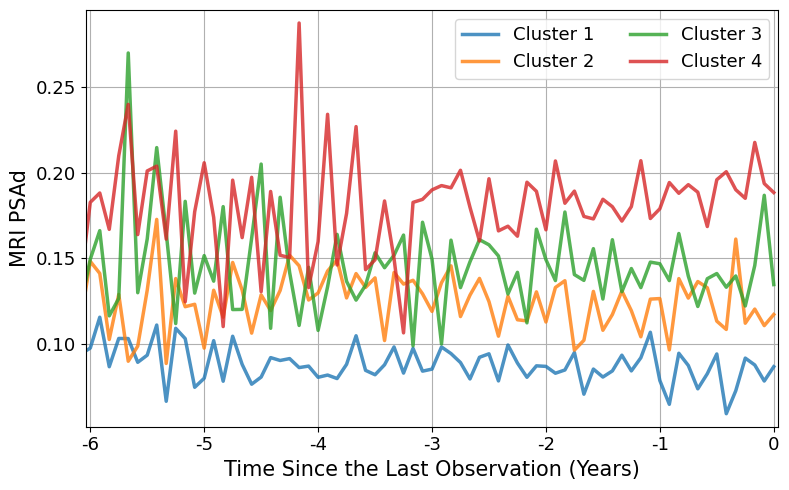

In [492]:

for f_idx, feat in enumerate(feat_timevarying):
    if f_idx != 0:
        start_idx = 0
        plt.figure(figsize=[8,5])

        plt.plot(tmp00[start_idx:, 0, 0], tmp00[start_idx:, f_idx, 0], 'C0', alpha=0.8, linewidth=2.5)
        plt.plot(tmp11[start_idx:, 0, 0], tmp11[start_idx:, f_idx, 0], 'C1', alpha=0.8, linewidth=2.5)
        plt.plot(tmp22[start_idx:, 0, 0], tmp22[start_idx:, f_idx, 0], 'C2', alpha=0.8, linewidth=2.5)
        plt.plot(tmp33[start_idx:, 0, 0], tmp33[start_idx:, f_idx, 0], 'C3', alpha=0.8, linewidth=2.5)

        plt.legend(['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], ncol=2, fontsize=13)
        plt.xticks((-72, -60, -48, -36, -24, -12, 0), ('-6', '-5', '-4', '-3', '-2', '-1', '0'), fontsize=13)
        plt.yticks(fontsize=13)
        plt.xlabel('Time Since the Last Observation (Years)', fontsize=15)
        plt.ylabel('{}'.format(feat.split("Repeat ")[1]), fontsize=15)
        plt.xlim([-72.5, 0.5])
        # plt.ylim([1, 13])

        plt.ylim([(np.min(tmp, axis=0)-tmp_margin)[f_idx], (np.max(tmp, axis=0) + tmp_margin)[f_idx]])
        plt.grid()
        plt.tight_layout()

        plt.savefig('./figures/temporal phenotypes/trajectories_{}.png'.format(feat.split("Repeat ")[1]), dpi=200)
        plt.show()
        plt.close()

In [451]:
feat_timevarying[f_idx].split("Repat ")[1]

'Biopsy Core Positive'

In [245]:
f_idx = 1

x_in_plot[:, :, 0]

array([[       nan,        nan,        nan, ..., 3.63758616, 4.15888308,
        4.61512052],
       [       nan,        nan,        nan, ...,        nan, 0.        ,
        3.63758616],
       [       nan,        nan,        nan, ..., 4.2341065 , 3.33220451,
        4.4308168 ],
       ...,
       [       nan,        nan,        nan, ..., 5.21493576, 4.49980967,
        4.52178858],
       [       nan,        nan,        nan, ..., 3.17805383, 3.4657359 ,
        3.8501476 ],
       [       nan,        nan,        nan, ..., 4.62497281, 4.52178858,
        4.73619845]])

In [1312]:
hist_kws=dict(edgecolor="gray", linewidth=1.)

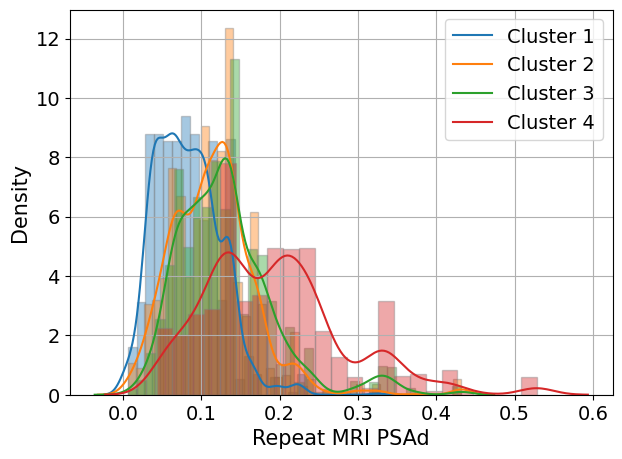

In [1361]:
plt.figure(figsize=[7,5])

f_idx = 8

sns.distplot(tmp_xt_[tmp_m2==1][pred_y==0, f_idx], norm_hist=True, hist_kws=hist_kws)
sns.distplot(tmp_xt_[tmp_m2==1][pred_y==1, f_idx], norm_hist=True, hist_kws=hist_kws)
sns.distplot(tmp_xt_[tmp_m2==1][pred_y==2, f_idx], norm_hist=True, hist_kws=hist_kws)
sns.distplot(tmp_xt_[tmp_m2==1][pred_y==3, f_idx], norm_hist=True, hist_kws=hist_kws)

plt.grid()

plt.xlabel(feat_timevarying[f_idx], fontsize=15)
plt.xticks(fontsize=14)
plt.ylabel('Density', fontsize=15)
plt.yticks(fontsize=14)

plt.legend(('Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'), fontsize=14)
# plt.savefig('./phenotype_{}.png'.format(feat_timevarying[f_idx]), dpi=200)
plt.show()
plt.close()

In [1319]:
tmp_grade1 = (xt_in[:, :, 4] == 0).astype(float)
tmp_grade2 = (xt_in[:, :, 4] == 1.).astype(float)

tmp_stage1 = (xt_in[:, :, 6] == 0).astype(float)
tmp_stage2 = (xt_in[:, :, 6] == 0.5).astype(float)
tmp_stage3 = (xt_in[:, :, 6] == 1.).astype(float)

array([1., 1., 1., ..., 0., 0., 0.])

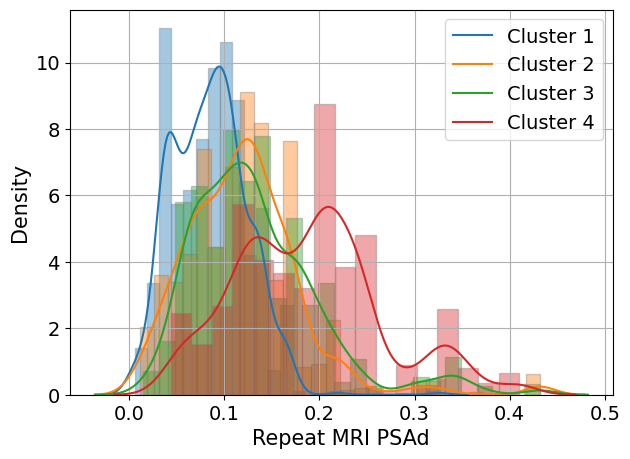

In [1360]:
plt.figure(figsize=[7,5])

f_idx = 8

sns.distplot(tmp_xt_[tmp_m2==1][(pred_y==0)*(tmp_stage2[tmp_m2==1]==1), f_idx], norm_hist=True, hist_kws=hist_kws)
sns.distplot(tmp_xt_[tmp_m2==1][(pred_y==1)*(tmp_stage2[tmp_m2==1]==1), f_idx], norm_hist=True, hist_kws=hist_kws)
sns.distplot(tmp_xt_[tmp_m2==1][(pred_y==2)*(tmp_stage2[tmp_m2==1]==1), f_idx], norm_hist=True, hist_kws=hist_kws)
sns.distplot(tmp_xt_[tmp_m2==1][(pred_y==3)*(tmp_stage2[tmp_m2==1]==1), f_idx], norm_hist=True, hist_kws=hist_kws)

plt.grid()

plt.xlabel(feat_timevarying[f_idx], fontsize=15)
plt.xticks(fontsize=14)
plt.ylabel('Density', fontsize=15)
plt.yticks(fontsize=14)

plt.legend(('Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'), fontsize=14)
# plt.savefig('./phenotype_{}.png'.format(feat_timevarying[f_idx]), dpi=200)
plt.show()
plt.close()

In [1350]:
np.sum(tmp_stage3[tmp_m2==1]==1)

5

In [1336]:
(pred_y==0)*(tmp_grade1[tmp_m2==1]).shape

array([0, 0, 0, ..., 0, 0, 0])

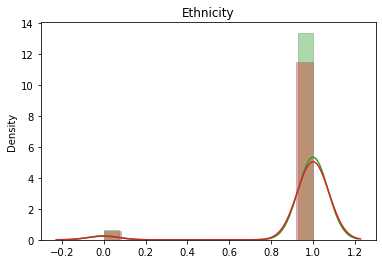

In [596]:
f_idx = 3

hist_kws=dict(edgecolor="gray", linewidth=1.)


sns.distplot(tmp_xs_[np.argmax(tmp_pi, axis=-1)[:, 0] == 0][:,f_idx], norm_hist=True, hist_kws=hist_kws)
sns.distplot(tmp_xs_[np.argmax(tmp_pi, axis=-1)[:, 0] == 8][:,f_idx], norm_hist=True, hist_kws=hist_kws)
sns.distplot(tmp_xs_[np.argmax(tmp_pi, axis=-1)[:, 0] == 3][:,f_idx], norm_hist=True, hist_kws=hist_kws)
sns.distplot(tmp_xs_[np.argmax(tmp_pi, axis=-1)[:, 0] == 9][:,f_idx], norm_hist=True, hist_kws=hist_kws)

plt.title(feat_static[f_idx])
plt.show()
plt.close()

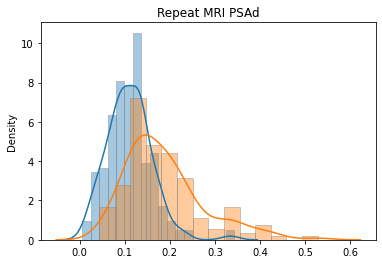

In [561]:
f_idx = 8

sns.distplot(tmp_xt_[np.argmax(tmp_pi, axis=-1)[:, 0] == 3, 0, :][:,f_idx], norm_hist=True, hist_kws=hist_kws)
sns.distplot(tmp_xt_[np.argmax(tmp_pi, axis=-1)[:, 0] == 9, 0, :][:,f_idx], norm_hist=True, hist_kws=hist_kws)

plt.title(feat_timevarying[f_idx])
plt.show()
plt.close()

In [29]:
f_idx = 1

sns.distplot(tmp_xt_[np.argmax(tmp_pi, axis=-1)[:, 0] == 3, 0, :][:,f_idx], norm_hist=True, hist_kws=hist_kws)
sns.distplot(tmp_xt_[np.argmax(tmp_pi, axis=-1)[:, 0] == 9, 0, :][:,f_idx], norm_hist=True, hist_kws=hist_kws)

plt.title(feat_timevarying[f_idx])
plt.show()
plt.close()

# EFFECT OF TEMPORAL FEATURES TO CLUSTERING ASSIGNMENTS and PREDICTIONS

In [35]:
feat_timevarying

array(['Delta', 'Repeat PSA', 'Repeat Biopsy Core Total',
       'Repeat Biopsy Core Positive', 'Repeat Biopsy Grade Group',
       'Repeat MRI PRECISE Scoring', 'Repeat MRI Stage',
       'Repeat MRI Volume', 'Repeat MRI PSAd'], dtype='<U31')

In [36]:
feat_timevarying[[1, 4, 6]]

array(['Repeat PSA', 'Repeat Biopsy Grade Group', 'Repeat MRI Stage'],
      dtype='<U31')

In [38]:
tmp_m1 = np.zeros_like(tmp_m2)

for i in range(len(seq_length)):
    tmp_m1[i, int(seq_length[i])-1] = 1.

In [41]:
mean_vals = xt_in[tmp_m2==1].mean(axis=0)

In [225]:
p99_vals  = np.percentile(xt_in[tmp_m2==1], 99., axis=0)

In [226]:
p99_vals

array([0.80786144, 0.48360084, 0.60784314, 0.66666667, 1.        ,
       1.        , 1.        , 0.69528889, 0.6281407 ])

In [227]:
tmp_pi[tmp_m1 == 1][:, list(pheno_mapper)]

array([[6.5885964e-25, 1.6754560e-10, 1.0000000e+00, 1.4005640e-13],
       [0.0000000e+00, 8.7816683e-34, 1.4457919e-13, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 2.2232045e-16, 1.0000000e+00],
       ...,
       [3.0698567e-32, 8.2578069e-18, 9.9998891e-01, 1.1118480e-05],
       [0.0000000e+00, 0.0000000e+00, 5.4856937e-17, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 3.4430629e-17, 1.0000000e+00]],
      dtype=float32)

In [228]:
np.unique(xt_in[tmp_m2 == 1][:, 6])

tmp_m1_prev = np.zeros_like(tmp_m1)
tmp_m1_prev[:, :-1] = tmp_m1[:, 1:]

In [621]:
import time

In [1123]:
f_idx1     = 1
f_idx2     = 8


_, tmp_pi, tmp_m2 = model.get_zbars_and_pis_m2(tr_data_s, tr_data_t)


feat_vals1 = np.linspace(np.percentile(tr_data_t[tmp_m2==1][:, f_idx1], 1), np.percentile(tr_data_t[tmp_m2==1][:, f_idx1], 99), 20)
feat_vals2 = np.linspace(np.percentile(tr_data_t[tmp_m2==1][:, f_idx2], 1), np.percentile(tr_data_t[tmp_m2==1][:, f_idx2], 99), 20)

In [865]:
con_list = [1, 2, 3, 7, 8]
bin_list = [4]

partial_dependence = dict()

xt_in = np.copy(tr_data_t)
xs_in = np.copy(tr_data_s)

_, tmp_pi, tmp_m2 = model.get_zbars_and_pis_m2(xs_in, xt_in)

# feat_vals = np.linspace(0., 1., 10)
feat_vals  = np.linspace(np.percentile(xt_in[tmp_m2==1][:, 1], 1), np.percentile(xt_in[tmp_m2==1][:, 1], 99), 20)


f_idx1     = 1
f_idx2     = 3

feat_vals1 = np.linspace(np.percentile(xt_in[tmp_m2==1][:, f_idx1], 1), np.percentile(xt_in[tmp_m2==1][:, f_idx1], 99), 20)
feat_vals2 = np.linspace(np.percentile(xt_in[tmp_m2==1][:, f_idx2], 1), np.percentile(xt_in[tmp_m2==1][:, f_idx2], 99), 20)

partial_dependence['original'] = tmp_pi[tmp_m1 == 1][:, list(pheno_mapper)]

for grade in [0., 1.]:
    for stage in [0., 0.5, 1.0]:
        tic = time.time()
        
        xt_in = np.copy(tr_data_t)

        xt_in[tmp_m1 == 1, :]    = mean_vals
#         xt_in[tmp_m1 == 1, :]    = p99_vals
#         xt_in[tmp_m1 == 1, :] = xt_in[tmp_m1_prev == 1]
        xt_in[tmp_m1 == 1, 4] = grade #{0,1}
        xt_in[tmp_m1 == 1, 6] = stage #{0, 0.5, 1}

        partial_dependence['({},{})'.format(grade, stage)] = np.zeros([len(feat_vals1), len(feat_vals2), np.shape(xt_in)[0], len(pheno_list)])

        for v_idx1, feat_val1 in enumerate(feat_vals1):
            for v_idx2, feat_val2 in enumerate(feat_vals2):
                xt_in[tmp_m1 == 1, f_idx1] = feat_val1
                xt_in[tmp_m1 == 1, f_idx2] = feat_val2

                _, tmp_pi, tmp_m2 = model.get_zbars_and_pis_m2(xs_in, xt_in)

                partial_dependence['({},{})'.format(grade, stage)][v_idx1, v_idx2] = tmp_pi[tmp_m1 == 1][:, list(pheno_mapper)]  
                
        toc = time.time()
        
        print(tic-toc)

-16.32145380973816
-16.138256311416626
-16.335851192474365
-16.09904956817627
-16.345718145370483
-17.34829092025757


In [1254]:
i = 237 #326

xt_in_  = np.zeros([seq_length[i], max_length, x_dim_timevarying])
xs_in_  = np.zeros([seq_length[i], x_dim_static])
tmp_m1  = np.zeros([seq_length[i], max_length])

for t in range(seq_length[i]):
    xs_in_[t, :]       = tr_data_s[i, :]
    xt_in_[t, :t+1, :] = tr_data_t[i, :t+1, :]
    tmp_m1[t, t]      = 1.
    
tmp_m1_prev = np.zeros_like(tmp_m1)
tmp_m1_prev[:, :-1] = tmp_m1[:, 1:]
tmp_m1_prev[0, 0]   = 1

xt_in = np.copy(xt_in_)
xs_in = np.copy(xs_in_)

con_list = [1, 2, 3, 7, 8]
bin_list = [4]

partial_dependence_indiv = dict()

_, tmp_pi, tmp_m2 = model.get_zbars_and_pis_m2(xs_in, xt_in)


partial_dependence_indiv['original'] = tmp_pi[tmp_m1 == 1][:, list(pheno_mapper)]

for grade in [0., 1.]:
    for stage in [0., 0.5, 1.0]:
        tic = time.time()
        
        xt_in = np.copy(xt_in_)

        xt_in[tmp_m1 == 1, :]    = mean_vals
#         xt_in[tmp_m1 == 1, :]    = p99_vals
#         xt_in[tmp_m1 == 1, :] = xt_in[tmp_m1_prev == 1, :]
        xt_in[tmp_m1 == 1, 4] = grade #{0,1}
        xt_in[tmp_m1 == 1, 6] = stage #{0, 0.5, 1}

        partial_dependence_indiv['({},{})'.format(grade, stage)] = np.zeros([len(feat_vals1), len(feat_vals2), np.shape(xt_in)[0], len(pheno_list)])

        for v_idx1, feat_val1 in enumerate(feat_vals1):
            for v_idx2, feat_val2 in enumerate(feat_vals2):
                xt_in[tmp_m1 == 1, f_idx1] = feat_val1
                xt_in[tmp_m1 == 1, f_idx2] = feat_val2

                _, tmp_pi, tmp_m2 = model.get_zbars_and_pis_m2(xs_in, xt_in)

                partial_dependence_indiv['({},{})'.format(grade, stage)][v_idx1, v_idx2] = tmp_pi[tmp_m1 == 1][:, list(pheno_mapper)]  
                
        toc = time.time()
        
        print(tic-toc)

-15.140969276428223
-14.621000289916992
-15.205520153045654
-16.048696517944336
-15.281060218811035
-15.945000171661377


In [1255]:
xt_in[tmp_m1 == 1, :].shape

(26, 9)

In [1256]:
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap0 = plt.get_cmap('Blues')
cmap0 = truncate_colormap(cmap0, 0.0, 0.65)
cmap0.set_bad('k', alpha=0.)

cmap1 = plt.get_cmap('Oranges')
cmap1 = truncate_colormap(cmap1, 0.0, 0.65)
cmap1.set_bad('k', alpha=0.)

cmap2 = plt.get_cmap('Greens')
cmap2 = truncate_colormap(cmap2, 0.0, 0.65)
cmap2.set_bad('k', alpha=0.)

cmap3 = plt.get_cmap('Reds')
cmap3 = truncate_colormap(cmap3, 0.0, 0.65)
cmap3.set_bad('k', alpha=0.)

1


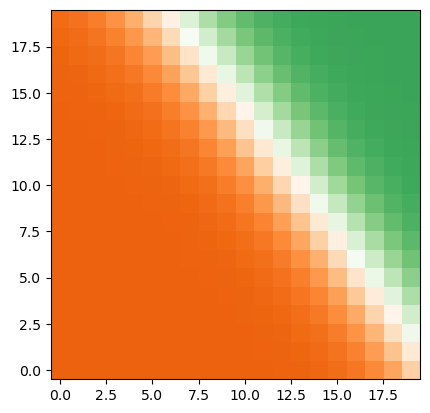

In [1257]:
grade = 0.
stage = 0.5

i = 127

print(np.argmax(partial_dependence['original'], axis=1)[i])

mat = partial_dependence['({},{})'.format(grade, stage)][:, :, i, :]

tmp_mask0 = (np.argmax(mat, axis=-1) == 0).astype(float)
tmp_mat0  = np.copy(mat[:, :, 0])
tmp_mat0[tmp_mask0 == 0] = np.nan

tmp_mask1 = (np.argmax(mat, axis=-1) == 1).astype(float)
tmp_mat1  = np.copy(mat[:, :, 1])
tmp_mat1[tmp_mask1 == 0] = np.nan

tmp_mask2 = (np.argmax(mat, axis=-1) == 2).astype(float)
tmp_mat2  = np.copy(mat[:, :, 2])
tmp_mat2[tmp_mask2 == 0] = np.nan

tmp_mask3 = (np.argmax(mat, axis=-1) == 3).astype(float)
tmp_mat3  = np.copy(mat[:, :, 3])
tmp_mat3[tmp_mask3 == 0] = np.nan


plt.imshow(tmp_mat0, vmax=1., vmin=0.5, origin='lower', cmap=cmap0)
plt.imshow(tmp_mat1, vmax=1., vmin=0.5, origin='lower', cmap=cmap1)
plt.imshow(tmp_mat2, vmax=1., vmin=0.5, origin='lower', cmap=cmap2)
plt.imshow(tmp_mat3, vmax=1., vmin=0.5, origin='lower', cmap=cmap3)


plt.show()
plt.close()

In [1258]:
print(mean_vals[f_idx2])
# feat_vals2

tmp_partial_dependence = np.zeros([len(feat_vals1), 6, len(xt_in), 4])

count = 0
for grade in [0., 1.]:
    for stage in [0., 0.5, 1.]:
        tmp_partial_dependence[:, count, :] = partial_dependence_indiv['({},{})'.format(grade, stage)][:, 6, :, :]
        count += 1

0.21905094233501907


In [ ]:
i = 13

plt.figure(figsize=(5,10))
print(np.argmax(partial_dependence_indiv['original'], axis=1)[i])

mat = tmp_partial_dependence[:, :, i, :]

tmp_mask0 = (np.argmax(mat, axis=-1) == 0).astype(float)
tmp_mat0  = np.copy(mat[:, :, 0])
tmp_mat0[tmp_mask0 == 0] = np.nan

tmp_mask1 = (np.argmax(mat, axis=-1) == 1).astype(float)
tmp_mat1  = np.copy(mat[:, :, 1])
tmp_mat1[tmp_mask1 == 0] = np.nan

tmp_mask2 = (np.argmax(mat, axis=-1) == 2).astype(float)
tmp_mat2  = np.copy(mat[:, :, 2])
tmp_mat2[tmp_mask2 == 0] = np.nan

tmp_mask3 = (np.argmax(mat, axis=-1) == 3).astype(float)
tmp_mat3  = np.copy(mat[:, :, 3])
tmp_mat3[tmp_mask3 == 0] = np.nan


plt.imshow(tmp_mat0, vmax=1., vmin=0.5, origin='lower', cmap=cmap0)
plt.imshow(tmp_mat1, vmax=1., vmin=0.5, origin='lower', cmap=cmap1)
plt.imshow(tmp_mat2, vmax=1., vmin=0.5, origin='lower', cmap=cmap2)
plt.imshow(tmp_mat3, vmax=1., vmin=0.5, origin='lower', cmap=cmap3)


plt.show()
plt.close()

In [1259]:
tmp_max1  = xt_max[f_idx1]
tmp_min1  = xt_min[f_idx1]
col_vals1 = feat_vals1 * (tmp_max1-tmp_min1) + tmp_min1
col_vals1 = ['{:.2f}'.format(val) for val in col_vals1]

tmp_max2  = xt_max[f_idx2]
tmp_min2  = xt_min[f_idx2]
col_vals2 = feat_vals2 * (tmp_max2-tmp_min2) + tmp_min2
col_vals2 = ['{:.2f}'.format(val) for val in col_vals2]

In [1260]:
grades = {
    0.: '1',
    1.: '2'
}
stages = {
    0.: '1',
    0.5: '2', 
    1.0: '3'
}

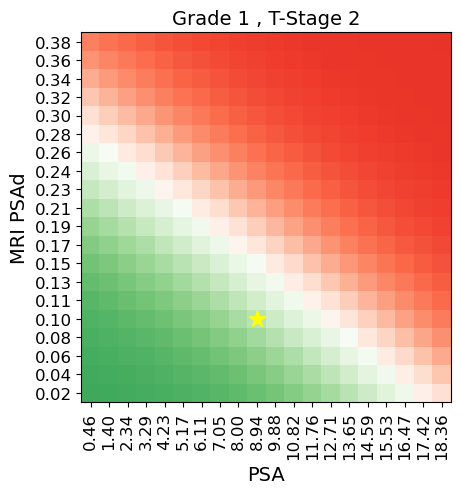

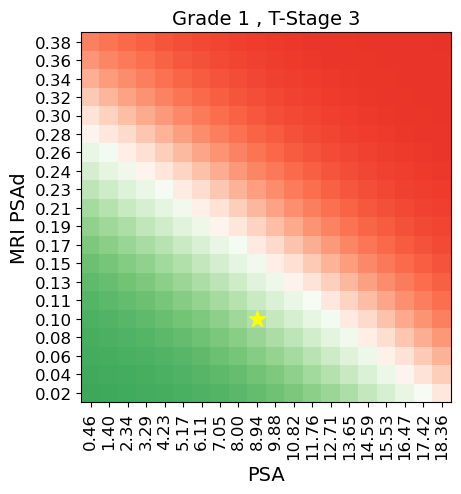

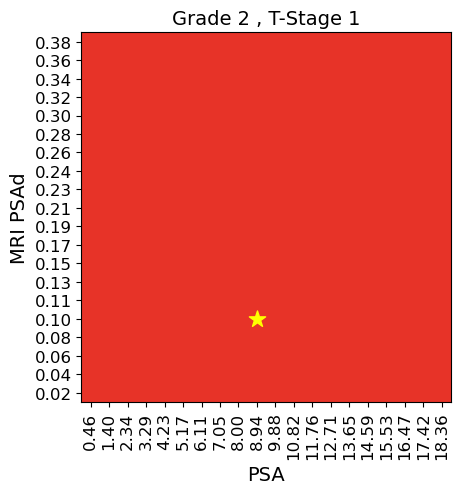

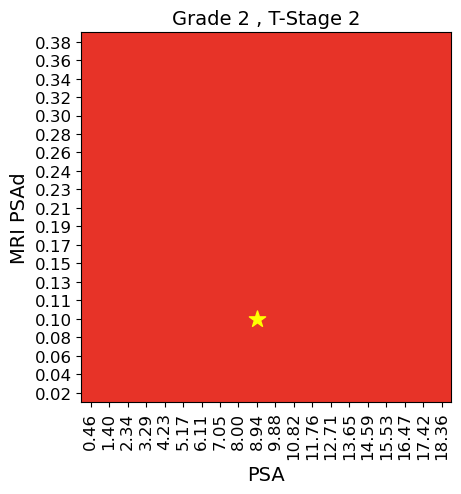

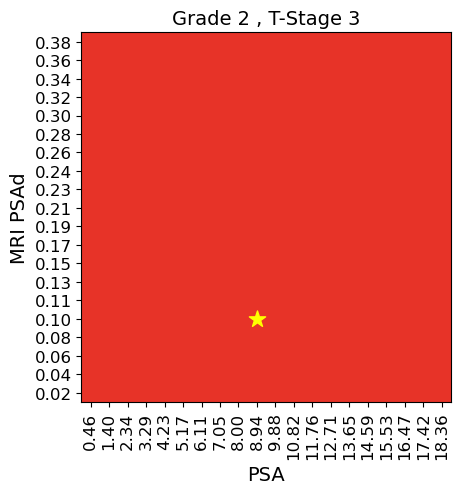

In [1294]:
j = 12 #4, 6, 12
save_mode = True

for grade in [0., 1.]:
    for stage in [0., 0.5, 1.]:

#         print(np.argmax(partial_dependence_indiv['original'], axis=1)[j])

        mat = partial_dependence_indiv['({},{})'.format(grade, stage)][:, :, j, :]

        tmp_mask0 = (np.argmax(mat, axis=-1) == 0).astype(float)
        tmp_mat0  = np.copy(mat[:, :, 0])
        tmp_mat0[tmp_mask0 == 0] = np.nan

        tmp_mask1 = (np.argmax(mat, axis=-1) == 1).astype(float)
        tmp_mat1  = np.copy(mat[:, :, 1])
        tmp_mat1[tmp_mask1 == 0] = np.nan

        tmp_mask2 = (np.argmax(mat, axis=-1) == 2).astype(float)
        tmp_mat2  = np.copy(mat[:, :, 2])
        tmp_mat2[tmp_mask2 == 0] = np.nan

        tmp_mask3 = (np.argmax(mat, axis=-1) == 3).astype(float)
        tmp_mat3  = np.copy(mat[:, :, 3])
        tmp_mat3[tmp_mask3 == 0] = np.nan


        plt.imshow(tmp_mat0, vmax=1., vmin=0.5, origin='lower', cmap=cmap0)
        plt.imshow(tmp_mat1, vmax=1., vmin=0.5, origin='lower', cmap=cmap1)
        plt.imshow(tmp_mat2, vmax=1., vmin=0.5, origin='lower', cmap=cmap2)
        plt.imshow(tmp_mat3, vmax=1., vmin=0.5, origin='lower', cmap=cmap3)

        plt.scatter(
            [np.where(feat_vals1 - xt_in_[j-1, j-1, f_idx1] > 0.)[0][0]], 
            [np.where(feat_vals2 - xt_in_[j-1, j-1, f_idx2] > 0.)[0][0]],
            color='yellow', s=150, marker='*')

        plt.xticks(np.arange(len(feat_vals1)), col_vals1, rotation=90, fontsize=12)
        plt.xlabel(feat_timevarying[f_idx1].split('Repeat ')[1], fontsize=14)

        plt.yticks(np.arange(len(feat_vals2)), col_vals2, fontsize=12)
        plt.ylabel(feat_timevarying[f_idx2].split('Repeat ')[1], fontsize=14)

        plt.title('Grade {} , T-Stage {}'.format(grades[grade], stages[stage]), fontsize=14)
        
        if save_mode == True:
            plt.savefig('./figures/temporal_phenotypes_threshold/pat{}_timestep{}_grade{}_stage{}.png'.format(i, j, grades[grade], stages[stage]), dpi=100)
        plt.show()
        plt.close()

In [306]:
pi_org = np.argmax(partial_dependence['original'], axis=1)

In [307]:
pi_news = np.zeros([len(feat_vals), len(pi_org)])

for v_idx, feat_val in enumerate(feat_vals):        
    pi_new = np.argmax(partial_dependence['({},{})'.format(1., 1.)][v_idx], axis=1)
    pi_news[v_idx, :] = pi_new

In [308]:
idx = np.sum(pi_news == 0, axis=0) == 10
np.sum(np.sum(pi_news == 0, axis=0) == 10)

59

In [309]:
np.sum(~idx)

315

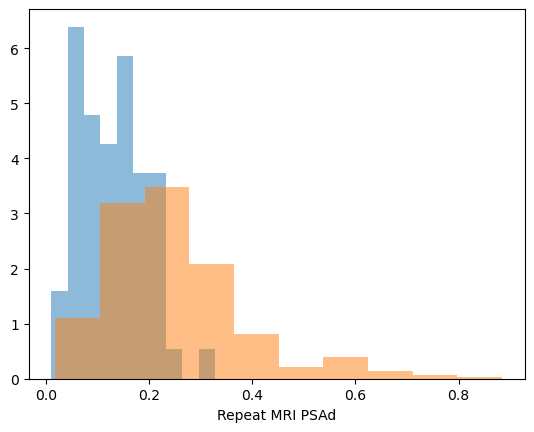

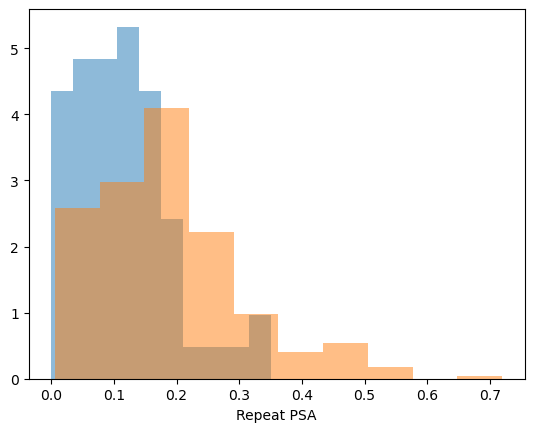

In [320]:
f_idx = 8

plt.hist(xt_in[tmp_m1_prev==1][idx, f_idx], alpha=0.5, density=True)
plt.hist(xt_in[tmp_m1_prev==1][~idx, f_idx], alpha=0.5, density=True)
plt.xlabel(feat_timevarying[f_idx])
plt.show()
plt.close()

f_idx = 1

plt.hist(xt_in[tmp_m1_prev==1][idx, f_idx], alpha=0.5, density=True)
plt.hist(xt_in[tmp_m1_prev==1][~idx, f_idx], alpha=0.5, density=True)
plt.xlabel(feat_timevarying[f_idx])
plt.show()
plt.close()

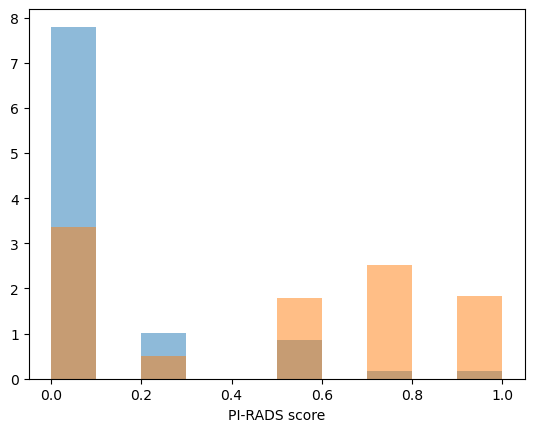

In [321]:
f_idx = 6

plt.hist(xs_in[idx, f_idx], alpha=0.5, density=True)
plt.hist(xs_in[~idx, f_idx], alpha=0.5, density=True)
plt.xlabel(feat_static[f_idx])
plt.show()
plt.close()

In [1367]:
con_list = [1, 2, 3, 7, 8]
bin_list = [4]


tmp_m1 = np.zeros_like(tmp_m2)

for i in range(len(seq_length)):
    tmp_m1[i, int(seq_length[i])-1] = 1.
    
    
tmp_m1_prev = np.zeros_like(tmp_m1)
tmp_m1_prev[:, :-1] = tmp_m1[:, 1:]


partial_dependence = dict()

xt_in = np.copy(tr_data_t)
xs_in = np.copy(tr_data_s)

_, tmp_pi, tmp_m2 = model.get_zbars_and_pis_m2(xs_in, xt_in)

partial_dependence['original'] = tmp_pi[tmp_m1 == 1][:, list(pheno_mapper)]

for f_idx, feat in enumerate(feat_timevarying):
    
    if f_idx != 0:        
        
        if f_idx in con_list:
#             feat_vals = np.linspace(0., 1., 10)
            feat_vals = np.linspace(np.percentile(xt_in[tmp_m2==1][:, f_idx], 1), np.percentile(xt_in[tmp_m2==1][:, f_idx], 99), 10)

        elif f_idx in [4]:
            feat_vals = np.asarray([0., 1.])
        elif f_idx == 5:
            feat_vals = np.asarray([0., 0.33333333, 0.66666667, 1.])
        elif f_idx == 6:
            feat_vals = np.asarray([0., 0.5, 1.])    

        partial_dependence[feat] = dict()
        
                
        for v_idx, feat_val in enumerate(feat_vals):        
            xt_in = np.copy(tr_data_t)
            xt_in[tmp_m1 == 1]        = xt_in[tmp_m1_prev == 1]
            xt_in[tmp_m1 == 1, f_idx] = feat_val

            _, tmp_pi, tmp_m2 = model.get_zbars_and_pis_m2(xs_in, xt_in)
            
            partial_dependence[feat][v_idx] = tmp_pi[tmp_m1 == 1][:, list(pheno_mapper)]
        

In [620]:
# for feat in feat_timevarying[1:]:
for feat in feat_timevarying[1:2]:    
    
    print(feat)

    transition_summary = np.zeros([len(partial_dependence[feat]), 2])
    
    transition     = np.zeros([len(partial_dependence[feat]), 4, 4])
    assignment_org = np.argmax(partial_dependence['original'], axis=1)

    for v_idx in range(len(partial_dependence[feat])):
        assignment_new = np.argmax(partial_dependence[feat][v_idx], axis=1)
        for i in range(4):
            for j in range(4):
                transition[v_idx, i, j] = np.sum((assignment_org == i) & (assignment_new == j))
        print(np.sum(np.triu(transition[v_idx], k=1)[~np.eye(4).astype(bool)]), np.sum(np.tril(transition[v_idx], k=-1)[~np.eye(4).astype(bool)]))
        


Repeat PSA
0.0 13.0
0.0 8.0
0.0 6.0
5.0 3.0
6.0 2.0
10.0 2.0
15.0 1.0
17.0 1.0
18.0 1.0
26.0 1.0


In [621]:


np.percentile(xt_in[tmp_m2==1][:, f_idx], 99)

0.628140703517588

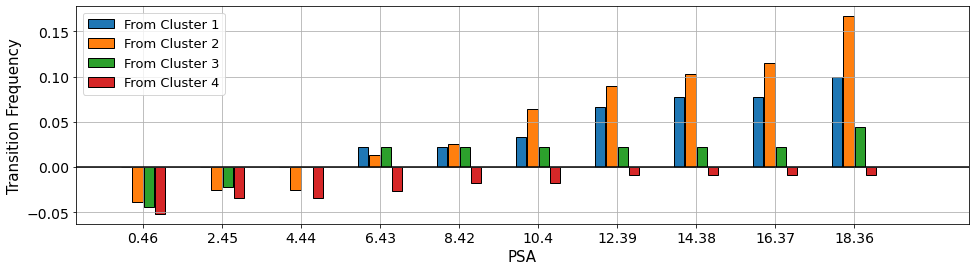

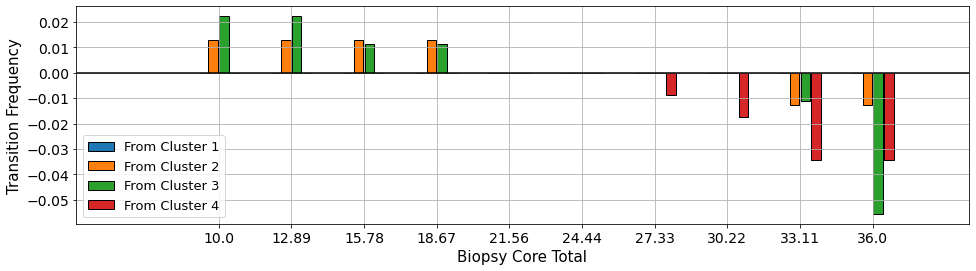

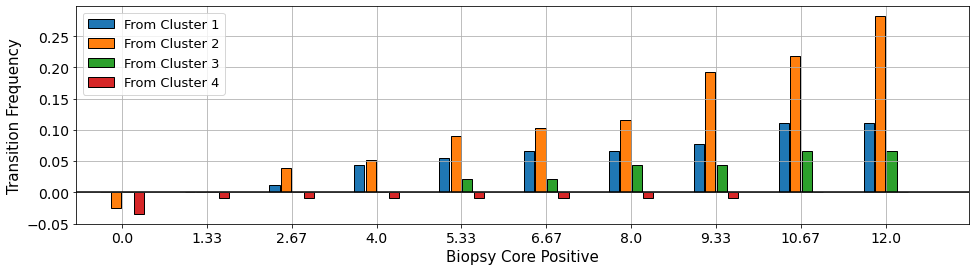

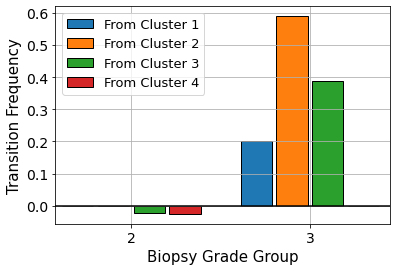

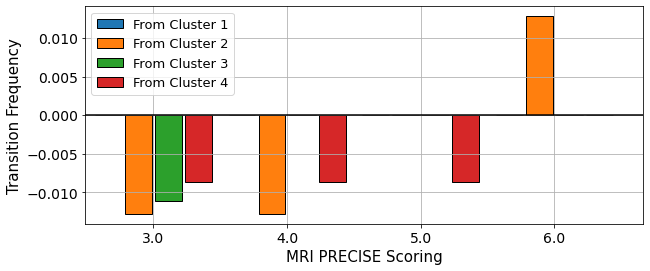

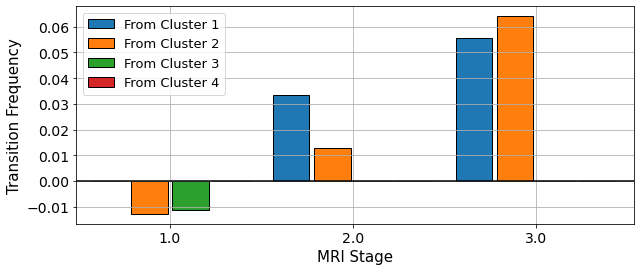

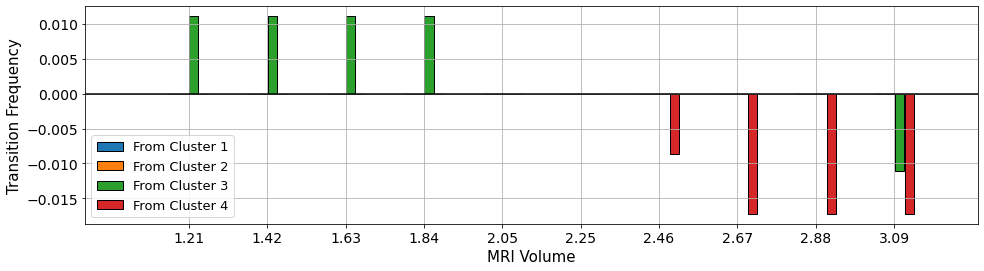

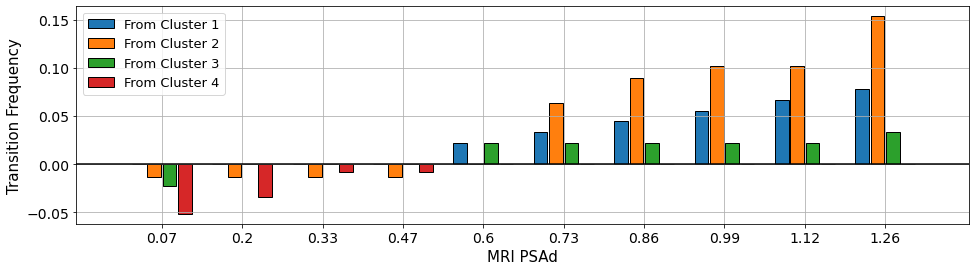

In [622]:
for f_idx in [1,2,3,4,5,6,7,8]:
    feat  = feat_timevarying[f_idx]

    transition     = np.zeros([len(partial_dependence[feat]), 4, 4])
    assignment_org = np.argmax(partial_dependence['original'], axis=1)

    for v_idx in range(len(partial_dependence[feat])):
        assignment_new = np.argmax(partial_dependence[feat][v_idx], axis=1)
        for i in range(4):
            for j in range(4):
                transition[v_idx, i, j] = np.sum((assignment_org == i) & (assignment_new == j))


    tmp_min = scaler_t.data_min_[f_idx]
    tmp_max = scaler_t.data_max_[f_idx]

    summary01 = np.zeros([len(partial_dependence[feat])])
    summary10 = np.zeros([len(partial_dependence[feat])])
    summary12 = np.zeros([len(partial_dependence[feat])])
    summary21 = np.zeros([len(partial_dependence[feat])])
    summary23 = np.zeros([len(partial_dependence[feat])])
    summary32 = np.zeros([len(partial_dependence[feat])])

    for v_idx in range(len(partial_dependence[feat])):
        tmp = transition[v_idx] / np.sum(transition[v_idx], axis=1, keepdims=True)

        summary01[v_idx] = tmp[0, 1]
        summary10[v_idx] = tmp[1, 0]
        summary12[v_idx] = tmp[1, 2]
        summary21[v_idx] = tmp[2, 1]
        summary23[v_idx] = tmp[2, 3]
        summary32[v_idx] = tmp[3, 2]


    if f_idx == 4:    
        plt.figure(figsize=[6,4])
        feat_vals = np.asarray(list(partial_dependence[feat]))

        space = 0.8

        plt.hlines(xmin=-10, xmax=10, y=0, colors='black')

        line1 = plt.bar(4*feat_vals, summary01, width=0.7, color='C0', edgecolor='black')
        line2 = plt.bar(4*feat_vals+space, summary12, width=0.7, color='C1', edgecolor='black')
        plt.bar(4*feat_vals+space, -summary10, width=0.7, color='C1', edgecolor='black')
        line3 = plt.bar(4*feat_vals+2*space, summary23, width=0.7, color='C2', edgecolor='black')
        plt.bar(4*feat_vals+2*space, -summary21, width=0.7, color='C2', edgecolor='black')
        line4 = plt.bar(4*feat_vals+3*space, -summary32, width=0.7, color='C3', edgecolor='black')

        plt.xlim([-0.5, 7])

        plt.xticks(4*feat_vals + space*3/2, (2, 3), fontsize=14)
        plt.yticks(fontsize=14)
        plt.ylabel('Transition Frequency', fontsize=15)
        plt.xlabel(feat.split('Repeat ')[-1],  fontsize=15)

    elif f_idx == 5:
        plt.figure(figsize=[10,4])
        feat_vals = np.asarray(list(partial_dependence[feat]))

        space = 0.09*10
        width = 0.08*10
        plt.hlines(xmin=-10, xmax=100, y=0, colors='black')

        line1 = plt.bar(4*feat_vals, summary01, width=width, color='C0', edgecolor='black')
        line2 = plt.bar(4*feat_vals+space, summary12, width=width, color='C1', edgecolor='black')
        plt.bar(4*feat_vals+space, -summary10, width=width, color='C1', edgecolor='black')
        line3 = plt.bar(4*feat_vals+2*space, summary23, width=width, color='C2', edgecolor='black')
        plt.bar(4*feat_vals+2*space, -summary21, width=width, color='C2', edgecolor='black')
        line4 = plt.bar(4*feat_vals+3*space, -summary32, width=width, color='C3', edgecolor='black')


        plt.xlim([-0.7, 16])


        plt.xticks(4*feat_vals + space*3/2, np.round(feat_vals * (tmp_max - tmp_min) + tmp_min, 2), fontsize=14)
        plt.yticks(fontsize=14)
        plt.ylabel('Transition Frequency', fontsize=15)
        plt.xlabel(feat.split('Repeat ')[-1],  fontsize=15)

    elif f_idx == 6:
        plt.figure(figsize=[10,4])
        feat_vals = np.asarray(list(partial_dependence[feat]))

        space = 0.09*10
        width = 0.08*10
        plt.hlines(xmin=-10, xmax=100, y=0, colors='black')

        line1 = plt.bar(4*feat_vals, summary01, width=width, color='C0', edgecolor='black')
        line2 = plt.bar(4*feat_vals+space, summary12, width=width, color='C1', edgecolor='black')
        plt.bar(4*feat_vals+space, -summary10, width=width, color='C1', edgecolor='black')
        line3 = plt.bar(4*feat_vals+2*space, summary23, width=width, color='C2', edgecolor='black')
        plt.bar(4*feat_vals+2*space, -summary21, width=width, color='C2', edgecolor='black')
        line4 = plt.bar(4*feat_vals+3*space, -summary32, width=width, color='C3', edgecolor='black')


        plt.xlim([-0.7, 11.5])


        plt.xticks(4*feat_vals + space*3/2, np.round(feat_vals * (tmp_max - tmp_min) + tmp_min, 2), fontsize=14)
        plt.yticks(fontsize=14)
        plt.ylabel('Transition Frequency', fontsize=15)
        plt.xlabel(feat.split('Repeat ')[-1],  fontsize=15)

    else:
        plt.figure(figsize=[16,4])
#         feat_vals = np.linspace(0, 1, 10)
        feat_vals = np.linspace(np.percentile(xt_in[tmp_m2==1][:, f_idx], 1), np.percentile(xt_in[tmp_m2==1][:, f_idx], 99), 10)

#         space = 0.09
#         width = 0.08
        space = 0.9 * (np.percentile(xt_in[tmp_m2==1][:, f_idx], 95) - np.percentile(xt_in[tmp_m2==1][:, f_idx], 5))/10
        width = 0.8 * (np.percentile(xt_in[tmp_m2==1][:, f_idx], 95) - np.percentile(xt_in[tmp_m2==1][:, f_idx], 5))/10
        
        plt.hlines(xmin=-10, xmax=10, y=0, colors='black')

        line1 = plt.bar(4*feat_vals, summary01, width=width, color='C0', edgecolor='black')
        line2 = plt.bar(4*feat_vals+space, summary12, width=width, color='C1', edgecolor='black')
        plt.bar(4*feat_vals+space, -summary10, width=width, color='C1', edgecolor='black')
        line3 = plt.bar(4*feat_vals+2*space, summary23, width=width, color='C2', edgecolor='black')
        plt.bar(4*feat_vals+2*space, -summary21, width=width, color='C2', edgecolor='black')
        line4 = plt.bar(4*feat_vals+3*space, -summary32, width=width, color='C3', edgecolor='black')


        plt.xlim([np.min(feat_vals)-0.1, np.max(4*feat_vals)+0.35])

        # if f_idx == 1:
        #     plt.ylim([-0.1, 0.46])
        # elif f_idx == 2:
        #     plt.ylim([-0.15, 0.05])
        # elif f_idx == 3:
        #     plt.ylim([-0.1, 0.46])
        # elif f_idx == 8:
        #     plt.ylim([-0.1, 0.3])

        plt.xticks(4*feat_vals + space*3/2, np.round(feat_vals * (tmp_max - tmp_min) + tmp_min, 2), fontsize=14)
        plt.yticks(fontsize=14)
        plt.ylabel('Transition Frequency', fontsize=15)
        plt.xlabel(feat.split('Repeat ')[-1],  fontsize=15)

    plt.legend((line1, line2, line3, line4), ('From Cluster 1', 'From Cluster 2', 'From Cluster 3', 'From Cluster 4'), fontsize=13)
    plt.grid()
    
    plt.savefig('./figures/temporal phenotypes/partial_dependcy_plot/{}.png'.format(feat.split('Repeat ')[-1]), bbox_inches="tight")
    plt.show()
    plt.close()

In [545]:
feat_vals

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

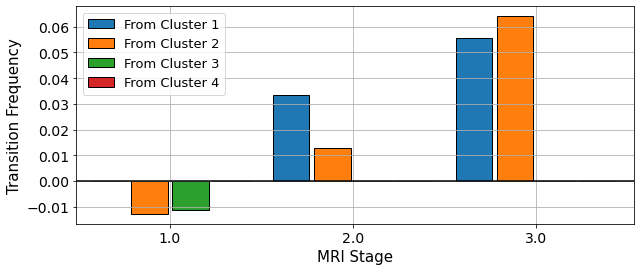

In [479]:
np.round(feat_vals * (tmp_max - tmp_min) + tmp_min,2)

array([3., 3.])

In [378]:
np.max(feat_vals)+0.8*2

2.6

In [481]:
tmp_min

3.0

In [312]:
feat_vals

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [271]:
transition[v_idx] / np.sum(transition[v_idx], axis=1, keepdims=True)

array([[0.86666667, 0.13333333, 0.        , 0.        ],
       [0.        , 0.71794872, 0.28205128, 0.        ],
       [0.        , 0.        , 0.9       , 0.1       ],
       [0.        , 0.        , 0.        , 1.        ]])

In [299]:
v_idx = 5
transition[v_idx] / np.sum(transition[v_idx], axis=1, keepdims=True)

array([[0.88888889, 0.11111111, 0.        , 0.        ],
       [0.        , 0.79487179, 0.20512821, 0.        ],
       [0.        , 0.        , 0.94444444, 0.05555556],
       [0.        , 0.        , 0.00862069, 0.99137931]])

In [286]:
feat = 'Repeat PSA'

transition     = np.zeros([len(partial_dependence[feat]), 4, 4])
assignment_org = np.argmax(partial_dependence['original'], axis=1)

for v_idx in range(len(partial_dependence[feat])):
    assignment_new = np.argmax(partial_dependence[feat][v_idx], axis=1)

    for i in range(4):
        for j in range(4):
            transition[v_idx, i, j] = np.sum((assignment_org == i) & (assignment_new == j))
    print(np.sum(np.triu(transition[v_idx], k=1)[~np.eye(4).astype(bool)]), np.sum(np.tril(transition[v_idx], k=-1)[~np.eye(4).astype(bool)]))

0.0 16.0
0.0 8.0
6.0 2.0
15.0 1.0
21.0 1.0
31.0 1.0
39.0 1.0
46.0 0.0
58.0 0.0
65.0 0.0


In [233]:
np.sum(assignment_org != assignment_new)

43

In [227]:
np.sum((assignment_org == 0) & (assignment_new == 1))

12

In [73]:
np.linspace(0., 1., 10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [78]:
np.unique(tr_data_t[tmp_m2 == 1][:, 8])

# np.percentile(np.unique(tr_data_t[tmp_m2 == 1][:, 0]), 95)

array([0.01005025, 0.01842546, 0.02512563, 0.03015075, 0.03350084,
       0.03517588, 0.03685092, 0.04020101, 0.04187605, 0.04690117,
       0.04857621, 0.0519263 , 0.05527638, 0.05862647, 0.06030151,
       0.06197655, 0.06365159, 0.06532663, 0.06700168, 0.06867672,
       0.07035176, 0.0720268 , 0.07370184, 0.07537688, 0.07705193,
       0.07872697, 0.08207705, 0.08542714, 0.08710218, 0.08877722,
       0.09045226, 0.0921273 , 0.09715243, 0.10050251, 0.10217755,
       0.1038526 , 0.10552764, 0.10720268, 0.10887772, 0.11055276,
       0.11222781, 0.11390285, 0.11557789, 0.11725293, 0.11892797,
       0.12060302, 0.12227806, 0.1239531 , 0.12562814, 0.12730318,
       0.12897822, 0.13065327, 0.13232831, 0.13400335, 0.13567839,
       0.13735343, 0.13902848, 0.14070352, 0.14237856, 0.1440536 ,
       0.14740369, 0.14907873, 0.15075377, 0.15410385, 0.15577889,
       0.15745394, 0.15912898, 0.16080402, 0.16247906, 0.1641541 ,
       0.16582915, 0.16750419, 0.16917923, 0.17085427, 0.17252

# Transition Figures 

In [1382]:
tmp_id = np.zeros_like(tmp_m2)
tmp_id[:, 0] = 1

df_first = pd.DataFrame(tmp_id[tmp_m2 == 1], columns=['first_id'])
df       = pd.DataFrame(pred_y, columns=['phenotype_curr'])
df['phenotype_curr']  = df['phenotype_curr'].apply(lambda x: pheno_mapper[x])

df = pd.concat([df_first, df], axis=1)
df['phenotype_prev'] = np.nan
df.iloc[1:, 2] = np.asarray(df['phenotype_curr'])[:-1]

In [1383]:
tmp_xs_prev = -1 * np.ones_like(tmp_xs)
tmp_xt_prev = -1 * np.ones_like(tmp_xt)

tmp_xs_prev[1:] = tmp_xs[:-1]
tmp_xt_prev[1:] = tmp_xt[:-1]

In [1384]:
matrix/np.sum(matrix, axis=1, keepdims=True)

array([[0.98584906, 0.01415094, 0.        , 0.        ],
       [0.06912442, 0.90585912, 0.02501646, 0.        ],
       [0.        , 0.11955891, 0.85780615, 0.02263494],
       [0.        , 0.        , 0.06972639, 0.93027361]])

In [1385]:
matrix = np.zeros([len(pheno_list), len(pheno_list)])

#current observations
cluster_xs = {}
cluster_xt = {}

#previous observations
cluster_xs_prev = {}
cluster_xt_prev = {}

for prev_c in pheno_list:
    for curr_c in pheno_list:
        tmp = df[(df['first_id'] != 1) & (df['phenotype_prev'] ==prev_c) & (df['phenotype_curr'] ==curr_c)]
        matrix[prev_c, curr_c] = np.shape(tmp)[0]
        cluster_xs['{},{}'.format(prev_c, curr_c)] = pd.DataFrame(tmp_xs[(df['first_id'] != 1) & (df['phenotype_prev'] ==prev_c) & (df['phenotype_curr'] ==curr_c)], columns=feat_static)
        cluster_xt['{},{}'.format(prev_c, curr_c)] = pd.DataFrame(tmp_xt[(df['first_id'] != 1) & (df['phenotype_prev'] ==prev_c) & (df['phenotype_curr'] ==curr_c)], columns=feat_timevarying)
        
        cluster_xs_prev['{},{}'.format(prev_c, curr_c)] = pd.DataFrame(tmp_xs_prev[(df['first_id'] != 1) & (df['phenotype_prev'] ==prev_c) & (df['phenotype_curr'] ==curr_c)], columns=feat_static)
        cluster_xt_prev['{},{}'.format(prev_c, curr_c)] = pd.DataFrame(tmp_xt_prev[(df['first_id'] != 1) & (df['phenotype_prev'] ==prev_c) & (df['phenotype_curr'] ==curr_c)], columns=feat_timevarying)   

In [1595]:
feat_timevarying

array(['Delta', 'Repeat PSA', 'Repeat Biopsy Core Total',
       'Repeat Biopsy Core Positive', 'Repeat Biopsy Grade Group',
       'Repeat MRI PRECISE Scoring', 'Repeat MRI Stage',
       'Repeat MRI Volume', 'Repeat MRI PSAd'], dtype='<U31')

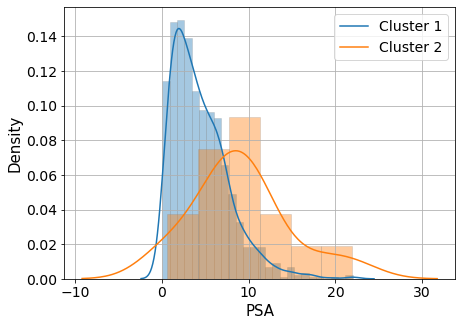

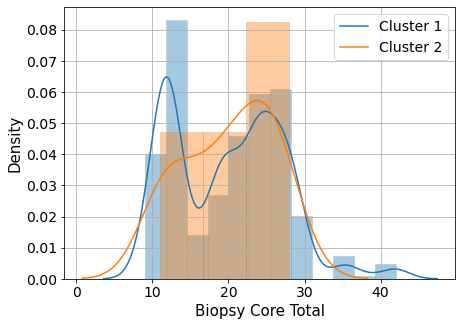

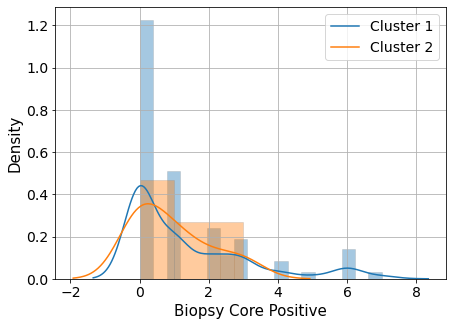

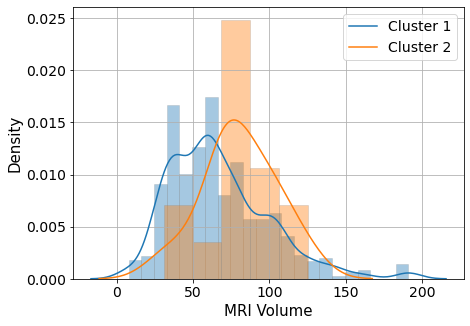

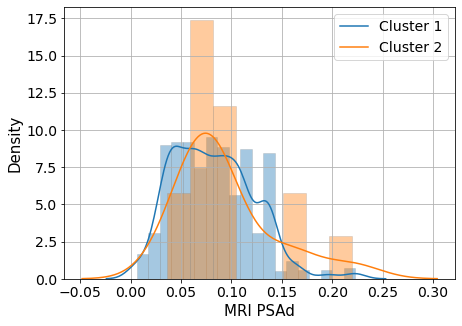

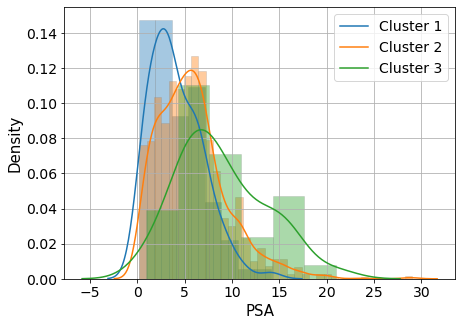

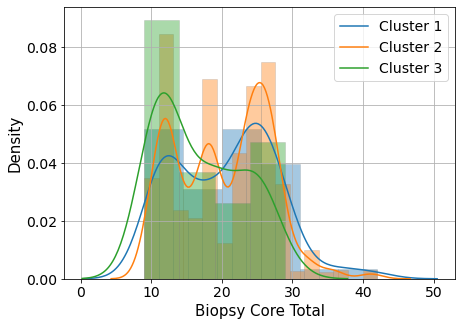

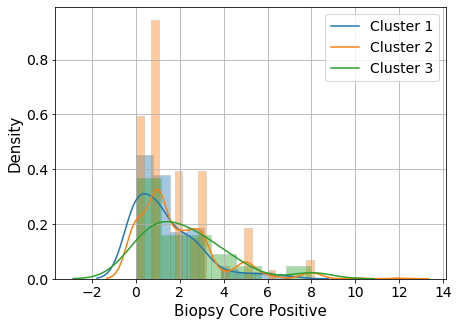

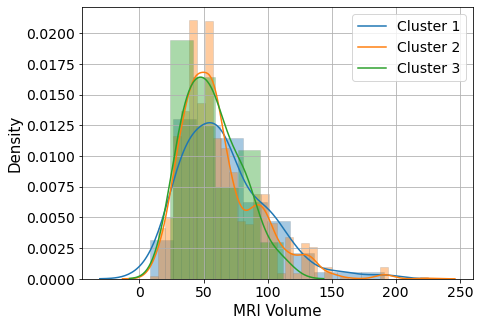

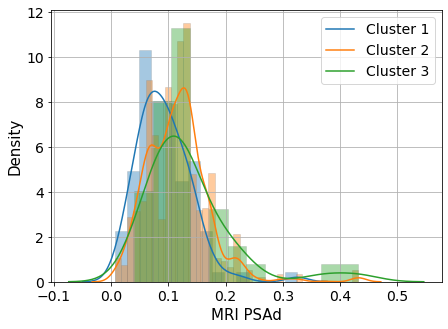

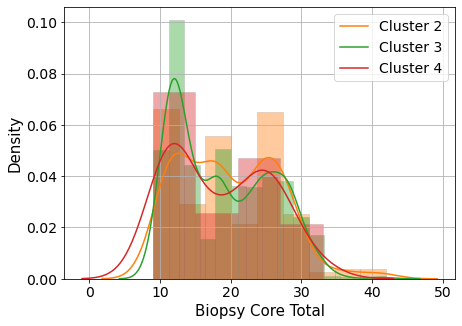

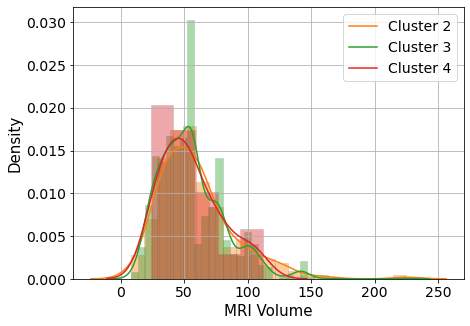

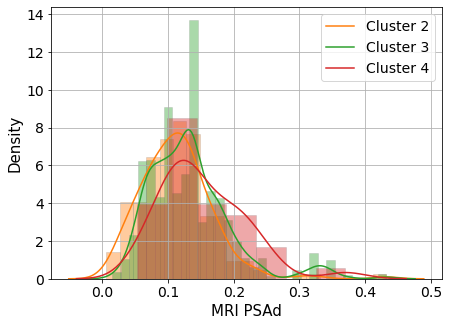

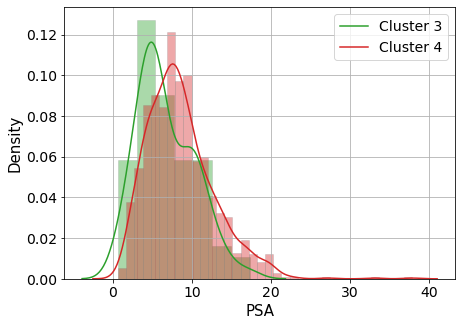

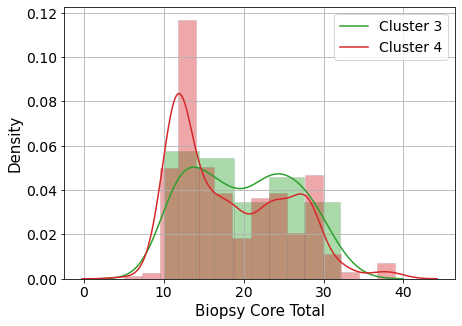

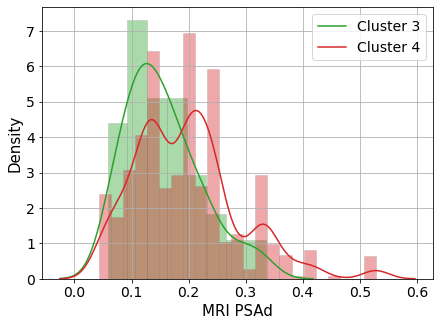

In [1597]:
for pheno_start in [0, 1, 2, 3]:
    for feat in ['Repeat PSA', 'Repeat Biopsy Core Total','Repeat Biopsy Core Positive', 'Repeat MRI Volume', 'Repeat MRI PSAd']:
        plt.figure(figsize=[7,5])
        hist_kws=dict(edgecolor="gray", linewidth=0.5)

        lines  = []
        labels = []

        if len(cluster_xt['{},0'.format(pheno_start)][feat]) != 0:
            line1 = sns.distplot(cluster_xt['{},0'.format(pheno_start)][feat], norm_hist=True, color='C0', hist_kws=hist_kws)
            lines += [line1]
            labels += ['Cluster 1']

        if len(cluster_xt['{},1'.format(pheno_start)][feat]) != 0:
            line2 = sns.distplot(cluster_xt['{},1'.format(pheno_start)][feat], norm_hist=True, color='C1', hist_kws=hist_kws)
            lines += [line2]
            labels += ['Cluster 2']

        if len(cluster_xt['{},2'.format(pheno_start)][feat]) != 0:
            line3 = sns.distplot(cluster_xt['{},2'.format(pheno_start)][feat], norm_hist=True, color='C2', hist_kws=hist_kws)
            lines += [line3]
            labels += ['Cluster 3']

        if len(cluster_xt['{},3'.format(pheno_start)][feat]) != 0:
            line4 = sns.distplot(cluster_xt['{},3'.format(pheno_start)][feat], norm_hist=True, color='C3', hist_kws=hist_kws)
            lines += [line4]
            labels += ['Cluster 4']


        plt.grid()
        # plt.xlim([0,30])

        plt.ylabel('Density', fontsize=15)
        plt.yticks(fontsize=14)
        plt.xlabel('{}'.format(feat.split('Repeat ')[1]), fontsize=15)
        plt.xticks(fontsize=14)

        plt.legend(labels, fontsize=14)
        plt.savefig('./figures/temporal phenotypes/transition_from{}_{}'.format(pheno_start, feat.split('Repeat ')[1]), dpi=200)
        plt.show()
        plt.close()

In [ ]:
feat = 'Repeat Biopsy Grade Group'
for pheno_start in [0,1,2,3]:
    if feat == 'Repeat MRI PRECISE Scoring':
        if pheno_start in [0,3]:
            tmp_bars = np.zeros([2, 5])
        else:
            tmp_bars = np.zeros([3, 5])
    else:
        if pheno_start in [0,3]:
            tmp_bars = np.zeros([2, 3])
        else:
            tmp_bars = np.zeros([3, 3])


    if pheno_start == 0:
        tmp_bars[0, cluster_xt['0,0'][feat].value_counts().index.astype(int)] = cluster_xt['0,0'][feat].value_counts().values
        tmp_bars[1, cluster_xt['0,1'][feat].value_counts().index.astype(int)] = cluster_xt['0,1'][feat].value_counts().values

    elif pheno_start == 1:
        tmp_bars[0, cluster_xt['1,0'][feat].value_counts().index.astype(int)] = cluster_xt['1,0'][feat].value_counts().values
        tmp_bars[1, cluster_xt['1,1'][feat].value_counts().index.astype(int)] = cluster_xt['1,1'][feat].value_counts().values
        tmp_bars[2, cluster_xt['1,2'][feat].value_counts().index.astype(int)] = cluster_xt['1,2'][feat].value_counts().values

    elif pheno_start == 2:
        tmp_bars[0, cluster_xt['2,1'][feat].value_counts().index.astype(int)] = cluster_xt['2,1'][feat].value_counts().values
        tmp_bars[1, cluster_xt['2,2'][feat].value_counts().index.astype(int)] = cluster_xt['2,2'][feat].value_counts().values
        tmp_bars[2, cluster_xt['2,3'][feat].value_counts().index.astype(int)] = cluster_xt['2,3'][feat].value_counts().values

    elif pheno_start == 3:
        tmp_bars[0, cluster_xt['3,2'][feat].value_counts().index.astype(int)] = cluster_xt['3,2'][feat].value_counts().values
        tmp_bars[1, cluster_xt['3,3'][feat].value_counts().index.astype(int)] = cluster_xt['3,3'][feat].value_counts().values

    if feat in ['Repeat Biopsy Grade Group', 'Repeat MRI PRECISE Scoring']:
        tmp_bars = tmp_bars[:, 1:]
    else:
        tmp_bars = tmp_bars[:, :-1] 
    tmp_bars = tmp_bars/np.sum(tmp_bars, axis=1, keepdims=True)


    plt.figure(figsize=[7,5])

    if pheno_start == 0:
        plt.bar(np.asarray([0, 1])-0.25, tmp_bars[0], width=0.2, color='C0')
        plt.bar(np.asarray([0, 1]), tmp_bars[1], width=0.2, color='C1')

        pheno_label = ['Cluster 1', 'Cluster 2']

    elif pheno_start == 1:
        plt.bar(np.asarray([0, 1])-0.25, tmp_bars[0], width=0.2, color='C0')
        plt.bar(np.asarray([0, 1]), tmp_bars[1], width=0.2, color='C1')
        plt.bar(np.asarray([0, 1])+0.25, tmp_bars[2], width=0.2, color='C2')

        pheno_label = ['Cluster 1', 'Cluster 2', 'Cluster 3']

    elif pheno_start == 2:
        plt.bar(np.asarray([0, 1])-0.25, tmp_bars[0], width=0.2, color='C1')
        plt.bar(np.asarray([0, 1]), tmp_bars[1], width=0.2, color='C2')
        plt.bar(np.asarray([0, 1])+0.25, tmp_bars[2], width=0.2, color='C3')

        pheno_label = ['Cluster 2', 'Cluster 3', 'Cluster 4']

    elif pheno_start == 3:
        plt.bar(np.asarray([0, 1])-0.25, tmp_bars[0], width=0.2, color='C2')
        plt.bar(np.asarray([0, 1]), tmp_bars[1], width=0.2, color='C3')

        pheno_label = ['Cluster 3', 'Cluster 4']

    # plt.title('{}'.format(feat))
    plt.grid()
    plt.ylim([0,1])
    plt.ylabel('Frequency', fontsize=15)
    plt.yticks(fontsize=14)

    plt.xlabel('{}'.format('Grade Group'), fontsize=15)
    plt.xticks((0,1), ('1','2'), fontsize=14)

    plt.legend(pheno_label, fontsize=12)

    plt.savefig('./figures/temporal phenotypes/transition_from{}_{}'.format(pheno_start, feat.split('Repeat ')[1]), dpi=200)
    plt.show()
    plt.close()

# PCA + Trajectory figures

In [1270]:
for i in np.where(y_in==0)[0]:
    print(i, np.argmax(tmp_pi, axis=2)[i, :int(np.sum(tmp_m2[i, :]))])


0 [9 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 8 8 8 8 8 8 8 8]
3 [3 3 3 3 3 3 3 3 3 8 8 8 8 8 8 8]
5 [3 3 3 8 8 8 8 8 8 8 0 0 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
6 [3 3 8 8 0 0 0 0 0 0 0 0 0 0 0 0 0]
7 [3 3 8 8 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
10 [3 3 8 8 8 8 8 8 8 8 8 8 8 8 3 3 3]
11 [3 8 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
12 [3 8 8 8 8 8 8 8 8 8 8 0 0]
13 [9 9 9 9]
14 [3 3 8 8 0 0 0 0 0 0 0 0 0 0 0 0]
15 [9 9 3 3 3 3 3 3 3 3 3 3]
16 [9 9 3 3 3 8 8 8 0 0 0 0 0 0 0 0 0]
18 [3 3 3 3 8 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
19 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
20 [3 3 3 3 8 8 8 8 8 8 8 8 0 0 0 0 0 0 0]
21 [3 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
23 [3 3 8 8 8 8 8 8 8]
24 [3 3 3 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 0 0 0]
26 [3 3 3 3 3 8 8 8 8 8 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 8 8 8 8 8 8]
27 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 

In [1263]:
for i in np.where(y_in)[0]:
    print(i, np.argmax(tmp_pi, axis=2)[i, :int(np.sum(tmp_m2[i, :]))])


1 [9 9]
2 [9 9 9 9]
4 [9 9 9 9 9 9 9 9 9]
9 [9 9 9 9 9 9]
17 [9 9 9 9 9]
22 [9 9 9 9 9 9 9 9 9]
25 [9 9 9]
30 [9 9 9 9 9]
34 [9 9 3 3 3 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
36 [9 9 9 9]
37 [9 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 9 9 9 9 9]
44 [9 9 3 3 9 9 9 9 9 9 9]
63 [9 9 9 9]
89 [9 3]
94 [9 9 9 9 3 3 3 3 3 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
114 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
120 [3 3 3 3 3 3 3 3 3 3 3 3 9 9 9 9 9]
149 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
158 [3 3 3 3 3 3 3 3 3 3 3 3 9 9 9 9 9]
161 [9 9 9 9 9 9 9 9 9 9 9 9]
176 [9 9 9 9 9 9 9]
183 [9 9 9 9]
186 [9 9 9 9 9 9 9 9 9 9 9]
191 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
199 [9 9 9 9 9 9 9 9 9]
205 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
210 [9 9]
211 [9 9 9 9 9 9]
213 [9 9 9]
221 [9 9 9 9 9 9 9]
225 [9 9 9 9 9 9 9 9 9 9 9 9 9]
227 [9 9 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
231 [9 9 9 9]
233 [9 9 9 9 9 9 9 9]
235 [3 3 3 3 3 3 9]
236 [9 9 9 9 9 9 9 9 9 9 9]
237 [3 3 3 3 3 

In [1674]:
pheno_assignment = np.argmax(tmp_pi, axis=2)
pheno_assignment[pheno_assignment == 0] = 0
pheno_assignment[pheno_assignment == 8] = 1
pheno_assignment[pheno_assignment == 3] = 2
pheno_assignment[pheno_assignment == 9] = 3

In [1687]:
npz = np.load('/home/vdslab/CH/Projects/prostate_temporal/STRATCANS_v1_new2/p1.0/itr2/models_actpc (version 2 - z initialization)/phenotypes.npz')

In [1681]:
np.savez(save_path + '/models_actpc (version 2 - z initialization)/phenotypes.npz',
        pheno_assignment = pheno_assignment,
        mask             = tmp_m2 )

In [146]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca   = PCA(n_components=2, random_state=seed)
z_pca = pca.fit_transform(tmp_z[tmp_m2==1])

In [147]:
i = 237
z_pca_event = pca.transform(tmp_z[i, :int(np.sum(tmp_m2[i, :])), :])

i = 326
z_pca_event0 = pca.transform(tmp_z[i, :int(np.sum(tmp_m2[i, :])), :])

In [155]:
tmp_z.shape

(374, 49, 200)

In [149]:
from matplotlib.legend import Legend


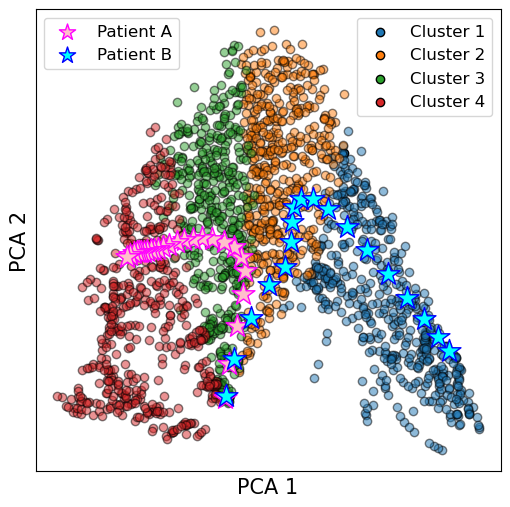

In [150]:
alpha_ = 0.5

nums = 500
idx0 = random.sample(range(np.sum(pred_y == 0)), nums)
idx1 = random.sample(range(np.sum(pred_y == 1)), nums)
idx2 = random.sample(range(np.sum(pred_y == 2)), nums)
idx3 = random.sample(range(np.sum(pred_y == 3)), nums)

fig, ax =  plt.subplots(figsize=[6,6])

pheno1 = ax.scatter(z_pca[pred_y == 0,0][0], z_pca[pred_y == 0,1][0], alpha=1.0, edgecolors='black', color='C0')
pheno2 = ax.scatter(z_pca[pred_y == 1,0][0], z_pca[pred_y == 1,1][0], alpha=1.0, edgecolors='black', color='C1')
pheno3 = ax.scatter(z_pca[pred_y == 2,0][0], z_pca[pred_y == 2,1][0], alpha=1.0, edgecolors='black', color='C2')
pheno4 = ax.scatter(z_pca[pred_y == 3,0][0], z_pca[pred_y == 3,1][0], alpha=1.0, edgecolors='black', color='C3')

ax.scatter(z_pca[pred_y == 0,0][idx0], z_pca[pred_y == 0,1][idx0], alpha=alpha_, edgecolors='black', color='C0')
ax.scatter(z_pca[pred_y == 1,0][idx1], z_pca[pred_y == 1,1][idx1], alpha=alpha_, edgecolors='black', color='C1')
ax.scatter(z_pca[pred_y == 2,0][idx2], z_pca[pred_y == 2,1][idx2], alpha=alpha_, edgecolors='black', color='C2')
ax.scatter(z_pca[pred_y == 3,0][idx3], z_pca[pred_y == 3,1][idx3], alpha=alpha_, edgecolors='black', color='C3')

line1 = ax.scatter(z_pca_event1[0, 0], z_pca_event1[0, 1], alpha=1., edgecolors='magenta', color='pink', marker='*', s= 150)
line2 = ax.scatter(z_pca_event0[0, 0], z_pca_event0[0, 1], alpha=1., edgecolors='blue', color='cyan', marker='*', s= 150)
ax.scatter(z_pca_event1[:, 0], z_pca_event1[:, 1], alpha=1., edgecolors='magenta', color='pink', marker='*', s= 300)
ax.scatter(z_pca_event0[:, 0], z_pca_event0[:, 1], alpha=1., edgecolors='blue', color='cyan', marker='*', s= 300)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('PCA 1', fontsize=15)
ax.set_ylabel('PCA 2', fontsize=15)

ax.legend([line1, line2], ['Patient A', 'Patient B'], fontsize=12, loc='upper left')
leg = Legend(ax, [pheno1, pheno2, pheno3, pheno4], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12, loc='upper right')
ax.add_artist(leg)

# plt.savefig('./phenotypes_pca.png', dpi=200)
plt.show()
plt.close()

# plt.scatter(z_pca_last[new_pred_y_last == 1,0], z_pca_last[new_pred_y_last == 1,1], alpha=alpha_, edgecolors='black', color='C0')
# plt.scatter(z_pca_last[new_pred_y_last == 2,0], z_pca_last[new_pred_y_last == 2,1], alpha=alpha_, edgecolors='black', color='C1')
# plt.scatter(z_pca_last[new_pred_y_last == 3,0], z_pca_last[new_pred_y_last == 3,1], alpha=alpha_, edgecolors='black', color='C2')
# plt.show()
# plt.close()


In [1638]:
data_xs_org = np.copy(data_xs)
data_xt_org = np.copy(data_xt)

data_xs_org = data_xs_org * (xs_max - xs_min) + xs_min
data_xt_org = data_xt_org * (xt_max - xt_min) + xt_min

data_xt_org = data_xt_org * (np.sum(data_xt, axis=2, keepdims=True) != 0).astype(float)

(tr_data_s_org,te_data_s_org, tr_data_t_org,te_data_t_org) = train_test_split(
    data_xs_org, data_xt_org, test_size=0.2, random_state=seed+out_itr
) 


(tr_data_s_org,va_data_s_org, tr_data_t_org,va_data_t_org) = train_test_split(
    tr_data_s_org, tr_data_t_org, test_size=0.2, random_state=seed+out_itr
)

In [1654]:
from models.cpg_score import predict_cpg

tmp_cpg = np.zeros([np.shape(tr_data_t)[0],np.shape(tr_data_t)[1]])

for i in range(np.shape(tr_data_t)[0]):
    tmp_cpg[i, :seq_length[i]] = predict_cpg(tr_data_t_org[i, :seq_length[i], 1], tr_data_t_org[i, :seq_length[i], 4], tr_data_t_org[i, :seq_length[i], 6], False)

In [1666]:
alpha_ = 0.5

nums = 1000
idx0 = random.sample(range(np.sum(pred_cpg == 1)), nums)
idx1 = random.sample(range(np.sum(pred_cpg == 2)), nums)
# idx2 = random.sample(range(np.sum(pred_y == 2)), nums)
# idx3 = random.sample(range(np.sum(pred_y == 3)), nums)

fig, ax =  plt.subplots(figsize=[6,6])

pheno1 = ax.scatter(z_pca[pred_cpg == 1,0][0], z_pca[pred_cpg == 1,1][0], alpha=1.0, edgecolors='black', color='C0')
pheno2 = ax.scatter(z_pca[pred_cpg == 2,0][0], z_pca[pred_cpg == 2,1][0], alpha=1.0, edgecolors='black', color='C1')
# pheno3 = ax.scatter(z_pca[pred_y == 2,0][0], z_pca[pred_y == 2,1][0], alpha=1.0, edgecolors='black', color='C2')
# pheno4 = ax.scatter(z_pca[pred_y == 3,0][0], z_pca[pred_y == 3,1][0], alpha=1.0, edgecolors='black', color='C3')

ax.scatter(z_pca[pred_cpg == 1,0][idx0], z_pca[pred_cpg == 1,1][idx0], alpha=alpha_, edgecolors='black', color='C0')
ax.scatter(z_pca[pred_cpg == 2,0][idx1], z_pca[pred_cpg == 2,1][idx1], alpha=alpha_, edgecolors='black', color='C1')
# ax.scatter(z_pca[pred_y == 2,0][idx2], z_pca[pred_y == 2,1][idx2], alpha=alpha_, edgecolors='black', color='C2')
# ax.scatter(z_pca[pred_y == 3,0][idx3], z_pca[pred_y == 3,1][idx3], alpha=alpha_, edgecolors='black', color='C3')

# line1 = ax.scatter(z_pca_event1[0, 0], z_pca_event1[0, 1], alpha=1., edgecolors='magenta', color='pink', marker='*', s= 150)
# line2 = ax.scatter(z_pca_event0[0, 0], z_pca_event0[0, 1], alpha=1., edgecolors='blue', color='cyan', marker='*', s= 150)
# ax.scatter(z_pca_event1[:, 0], z_pca_event1[:, 1], alpha=1., edgecolors='magenta', color='pink', marker='*', s= 300)
# ax.scatter(z_pca_event0[:, 0], z_pca_event0[:, 1], alpha=1., edgecolors='blue', color='cyan', marker='*', s= 300)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('PCA 1', fontsize=15)
ax.set_ylabel('PCA 2', fontsize=15)

# ax.legend([line1, line2], ['Patient A', 'Patient B'], fontsize=12, loc='upper left')
leg = Legend(ax, [pheno1, pheno2], ['CPG 1', 'CPG 2'], fontsize=12, loc='upper right')
ax.add_artist(leg)

plt.savefig('./cpg_pca.png', dpi=200)
plt.show()
plt.close()

# plt.scatter(z_pca_last[new_pred_y_last == 1,0], z_pca_last[new_pred_y_last == 1,1], alpha=alpha_, edgecolors='black', color='C0')
# plt.scatter(z_pca_last[new_pred_y_last == 2,0], z_pca_last[new_pred_y_last == 2,1], alpha=alpha_, edgecolors='black', color='C1')
# plt.scatter(z_pca_last[new_pred_y_last == 3,0], z_pca_last[new_pred_y_last == 3,1], alpha=alpha_, edgecolors='black', color='C2')
# plt.show()
# plt.close()
